## <a name="C4"> Projet 5 : Segmentez les clients d'un site de e-commerce</a>
## <a name="C4"> 3 : Modélisation</a>

La segmentation par modélisation K-means est une technique essentielle dans l'analyse des données et le marketing, car elle permet de diviser une population de clients en groupes homogènes basés sur leurs comportements et caractéristiques similaires. En utilisant l'algorithme K-means, les entreprises peuvent identifier des segments distincts de clients, facilitant ainsi la personnalisation des offres et des communications marketing. Cette approche aide à découvrir des patterns cachés dans les données, permettant une meilleure compréhension des besoins et préférences des clients. De plus, la segmentation K-means est flexible et peut s'adapter à différents types de données et de critères, rendant l'analyse plus pertinente et efficace. En fin de compte, cela permet aux entreprises de cibler plus précisément leurs campagnes marketing, d'optimiser les ressources et d'améliorer la satisfaction et la fidélisation des clients.

## <a name="C4"> Mise en place de l'environnement de travail</a>

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl 
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import squarify
from math import pi
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import DBSCAN
from sklearn.model_selection import ParameterGrid
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy import stats
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from scipy.spatial.distance import euclidean
from itertools import combinations
from sklearn.pipeline import Pipeline
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

print("Librairies importées avec succès !")

Librairies importées avec succès !


In [3]:
print("Version of the libraries used")
print("-----------------------------")
print("Pandas:", pd.__version__)
print("NumPy:", np.__version__)
print("Matplotlib:", plt.matplotlib.__version__)
print("Seaborn:", sns.__version__)

Version of the libraries used
-----------------------------
Pandas: 2.0.3
NumPy: 1.24.3
Matplotlib: 3.7.2
Seaborn: 0.12.2


- Création des fonctions utiles

In [4]:
def data_info(df: pd.DataFrame):
    desc = df.columns.to_frame(name="colonne").set_index('colonne')
    desc['nombre de valeurs non nulles'] = df.notnull().sum() 
    desc['nombre de valeurs uniques'] = df.nunique() 
    desc['type de donnée'] = df.dtypes 
    desc['nombre de valeurs nulles']=df.isna().sum()
    desc['pourcentage de valeurs nulles']=round((df.isna().sum()/df.shape[0]*100),2)
    return desc

# Indication de réussite
print("Fonction data_info créée avec succès !")

Fonction data_info créée avec succès !


In [5]:
def fill_rates_plot(dataframe, ignore_columns=None):
    # Filtrer les colonnes si nécessaire
    if ignore_columns is not None:
        dataframe = dataframe.drop(columns=ignore_columns, errors='ignore')

    # Calcul du taux de remplissage pour chaque colonne
    fill_rates = dataframe.notnull().mean() * 100

    # Création de l'histogramme
    plt.figure(figsize=(25, 4))
    fill_rates.plot(kind='bar', color='steelblue')
    plt.title('Taux de remplissage des colonnes')
    plt.xlabel('Colonnes')
    plt.ylabel('Taux de remplissage (%)')
    plt.xticks(rotation=90)
    plt.grid(True, linestyle='--', linewidth=0.5, color='lightsteelblue')
    
    # Affichage de l'histogramme
    plt.show()
    
# Indication de réussite
print("Fonction fill_rates_plot créée avec succès !")

Fonction fill_rates_plot créée avec succès !


- Lecture des fichiers de données

In [6]:
data = pd.read_csv('data.csv', sep = ";")
rfm = pd.read_csv('rfm.csv', sep = ";")
rfm_2 = pd.read_csv('rfm_2.csv', sep = ";")
features = pd.read_csv('features.csv', sep = ";")
print("Fichier importé avec succès !")

Fichier importé avec succès !


In [7]:
data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,...,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,delivery_delay
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,1,credit_card,1,18.12,a54f0611adc9ed256b57ede6b6eb5114,4,3149.0,-23.576983,-46.587161,8
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,3,voucher,1,2.00,a54f0611adc9ed256b57ede6b6eb5114,4,3149.0,-23.576983,-46.587161,8
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,2,voucher,1,18.59,a54f0611adc9ed256b57ede6b6eb5114,4,3149.0,-23.576983,-46.587161,8
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,1,credit_card,3,37.77,b46f1e34512b0f4c74a72398b03ca788,4,3366.0,-23.564630,-46.534268,2
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,1,credit_card,1,37.77,dc90f19c2806f1abba9e72ad3c350073,5,2290.0,-23.600462,-46.655318,5


In [8]:
rfm.head()

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19
2,0000f46a3911fa3c0805444483337064,538,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,289,1,196.89


In [9]:
rfm_2.head()

,customer_unique_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,rfm_score,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90,4,1,4,414,Promising
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19,4,1,1,411,New Customers
2,0000f46a3911fa3c0805444483337064,538,1,86.22,1,1,2,112,Lost customers
3,0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62,2,1,1,211,Hibernating customers
4,0004aac84e0df4da2b147fca70cf8255,289,1,196.89,2,1,4,214,Cannot Lose Them


In [10]:
features.head()

,customer_unique_id,total_items,average_installments,freight,average_delivery_delay,average_review_score
0,0000366f3b9a7992bf8c76cfdf3221e2,1,8.0,0.08,6.0,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,1.0,0.30,3.0,4.0
2,0000f46a3911fa3c0805444483337064,1,8.0,0.20,25.0,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,1,4.0,0.40,20.0,4.0
4,0004aac84e0df4da2b147fca70cf8255,1,6.0,0.09,13.0,5.0


In [11]:
df = pd.merge(rfm, features, on='customer_unique_id')
df.set_index("customer_unique_id", inplace=True)
df.head()

,recency,frequency,monetary,total_items,average_installments,freight,average_delivery_delay,average_review_score
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90,1,8.0,0.08,6.0,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19,1,1.0,0.30,3.0,4.0
0000f46a3911fa3c0805444483337064,538,1,86.22,1,8.0,0.20,25.0,3.0
0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62,1,4.0,0.40,20.0,4.0
0004aac84e0df4da2b147fca70cf8255,289,1,196.89,1,6.0,0.09,13.0,5.0


## <a name="C4"> Préparation des données </a>

- Visualisation des distributions

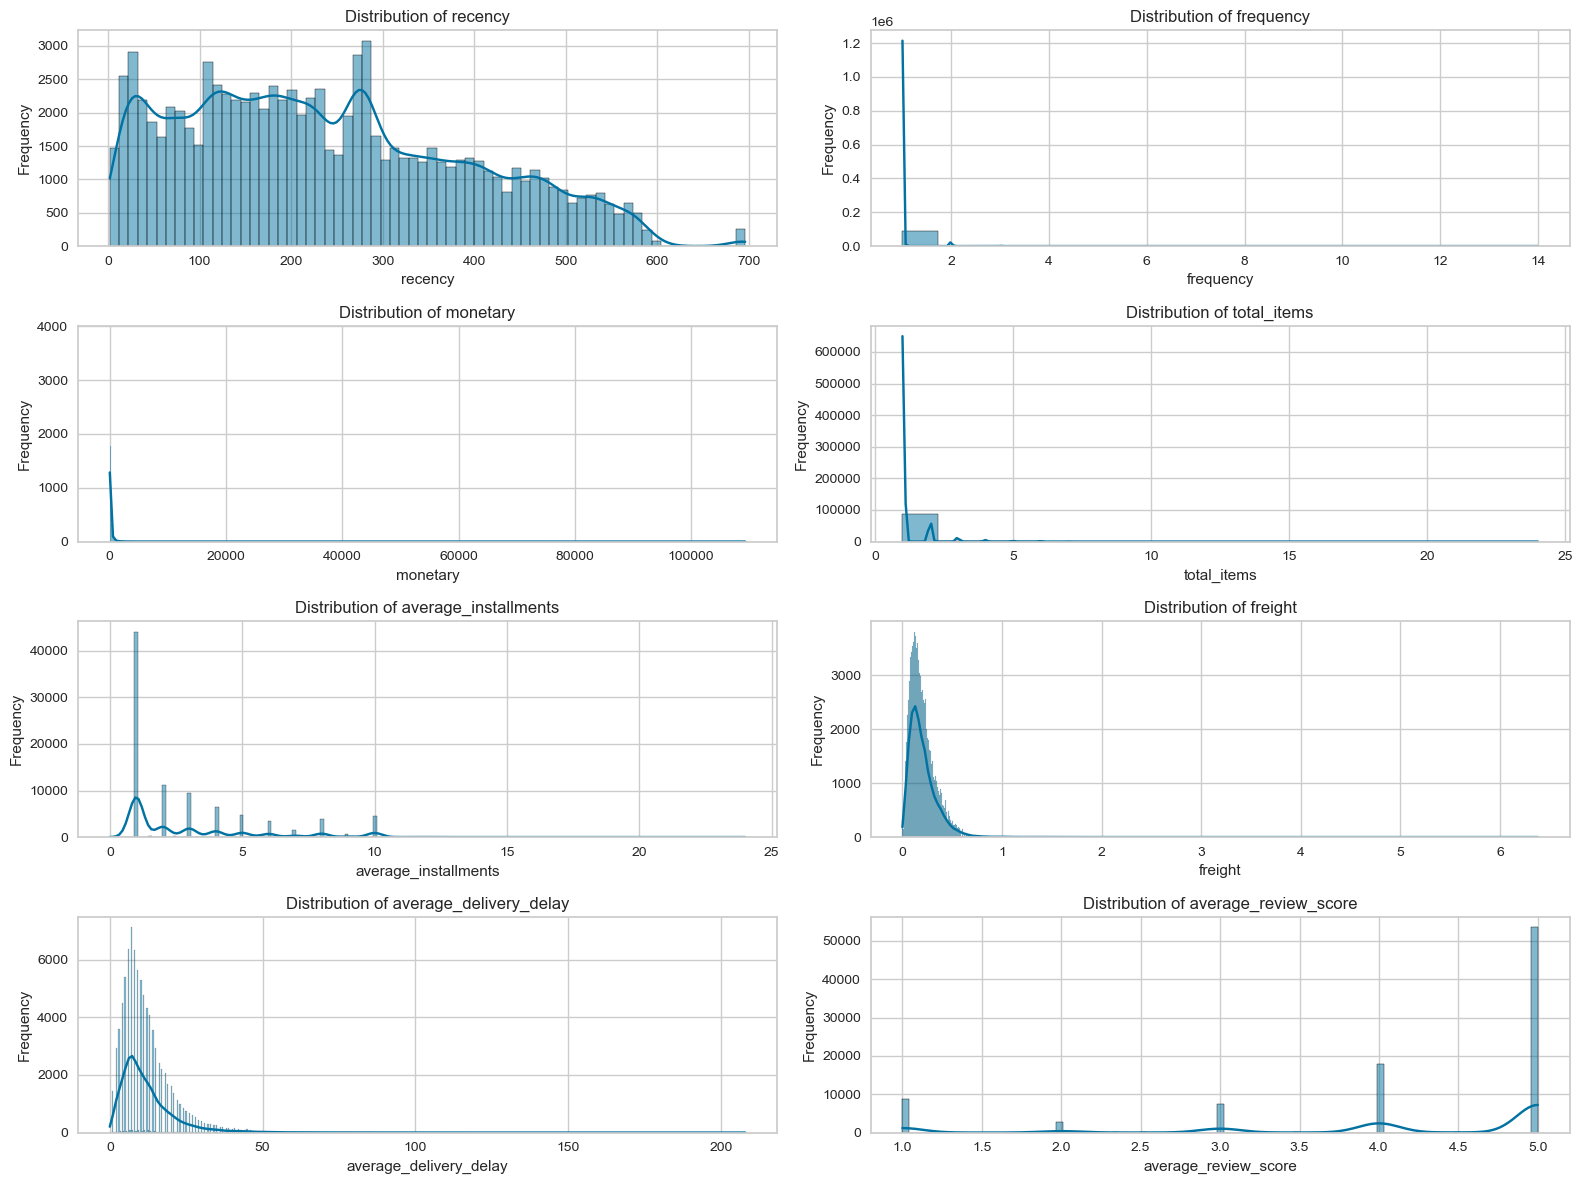

In [12]:
variables = ['recency', 'frequency', 'monetary', 'total_items', 
             'average_installments', 'freight', 
             'average_delivery_delay', 'average_review_score']

plt.figure(figsize=(16, 12))
for i, var in enumerate(variables, 1):
    plt.subplot(4, 2, i)
    sns.histplot(df[var], kde=True)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,91229.0,238.172895,152.637808,2.00,115.00,219.00,346.00,696.00
frequency,91229.0,1.032851,0.206191,1.00,1.00,1.00,1.00,14.00
monetary,91229.0,212.322901,631.845612,9.59,63.83,112.87,202.76,109312.64
total_items,91229.0,1.179154,0.615599,1.00,1.00,1.00,1.00,24.00
average_installments,91229.0,2.902973,2.680002,0.00,1.00,2.00,4.00,24.00
freight,91229.0,0.204080,0.152698,0.00,0.11,0.17,0.26,6.38
average_delivery_delay,91229.0,12.048788,9.455858,0.00,6.00,10.00,15.00,208.00
average_review_score,91229.0,4.154359,1.279412,1.00,4.00,5.00,5.00,5.00


- Transformation logarithmique

In [14]:
df_log = df.copy()
columns_to_log = ['frequency', 'monetary', 'total_items', 'average_review_score', 'average_delivery_delay']
df_log['average_delivery_delay'] = df_log['average_delivery_delay'] + 1

for column in columns_to_log:
    if column in df_log.columns:
        df_log[column] = np.log10(df_log[column])

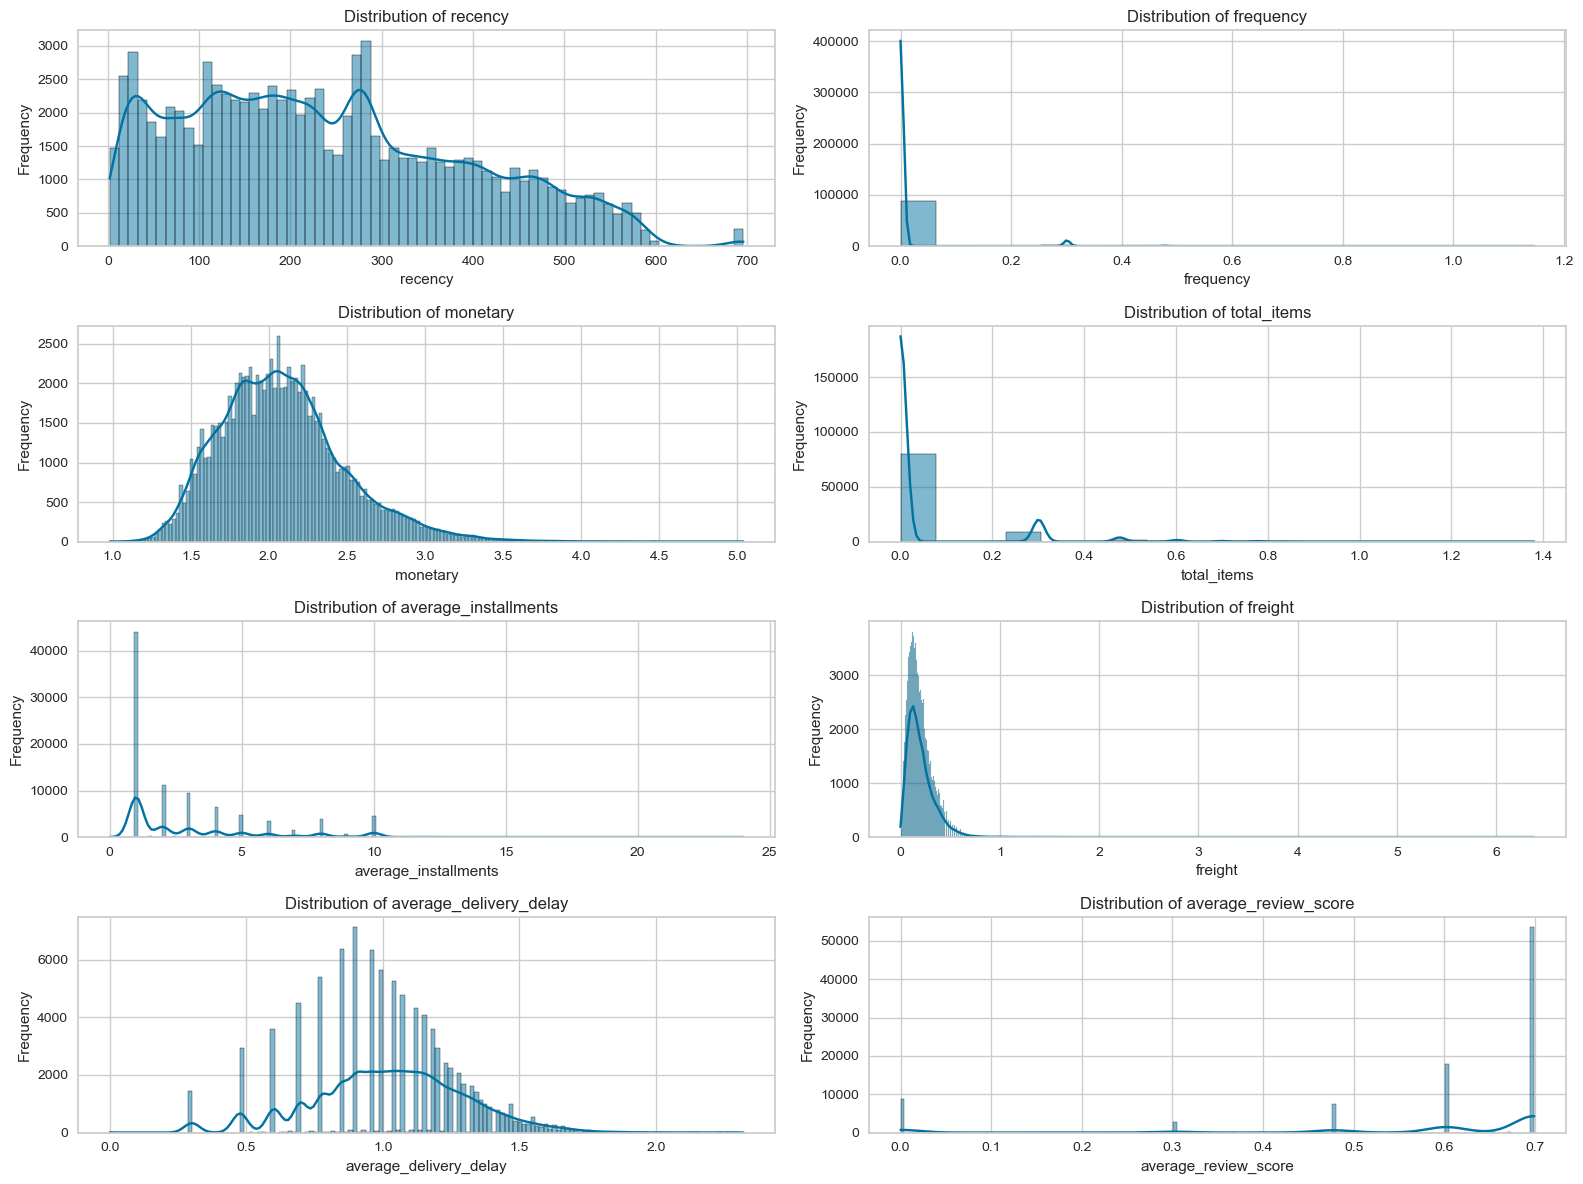

In [15]:
plt.figure(figsize=(16, 12))
for i, var in enumerate(variables, 1):
    plt.subplot(4, 2, i)
    sns.histplot(df_log[var], kde=True)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [16]:
df_log.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,91229.0,238.172895,152.637808,2.000000,115.000000,219.000000,346.000000,696.000000
frequency,91229.0,0.009412,0.055039,0.000000,0.000000,0.000000,0.000000,1.146128
monetary,91229.0,2.085356,0.397896,0.981819,1.805025,2.052579,2.306982,5.038670
total_items,91229.0,0.045105,0.128220,0.000000,0.000000,0.000000,0.000000,1.380211
average_installments,91229.0,2.902973,2.680002,0.000000,1.000000,2.000000,4.000000,24.000000
freight,91229.0,0.204080,0.152698,0.000000,0.110000,0.170000,0.260000,6.380000
average_delivery_delay,91229.0,1.028699,0.275691,0.000000,0.845098,1.041393,1.204120,2.320146
average_review_score,91229.0,0.581460,0.209767,0.000000,0.602060,0.698970,0.698970,0.698970


- Standardisation

In [17]:
df_log

,recency,frequency,monetary,total_items,average_installments,freight,average_delivery_delay,average_review_score
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,113,0.0,2.151982,0.00000,8.0,0.08,0.845098,0.698970
0000b849f77a49e4a4ce2b2a4ca5be3f,116,0.0,1.434409,0.00000,1.0,0.30,0.602060,0.602060
0000f46a3911fa3c0805444483337064,538,0.0,1.935608,0.00000,8.0,0.20,1.414973,0.477121
0000f6ccb0745a6a4b88665a16c9f078,322,0.0,1.639686,0.00000,4.0,0.40,1.322219,0.602060
0004aac84e0df4da2b147fca70cf8255,289,0.0,2.294224,0.00000,6.0,0.09,1.146128,0.698970
...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,448,0.0,3.616459,0.30103,10.0,0.12,1.447158,0.698970
fffea47cd6d3cc0a88bd621562a9d061,263,0.0,1.927268,0.00000,1.0,0.23,1.491362,0.602060
ffff371b4d645b6ecea244b27531430a,569,0.0,2.050998,0.00000,1.0,0.20,1.176091,0.698970


In [18]:
scaler = StandardScaler()
df_log_scaled = pd.DataFrame(scaler.fit_transform(df_log), columns=df_log.columns)

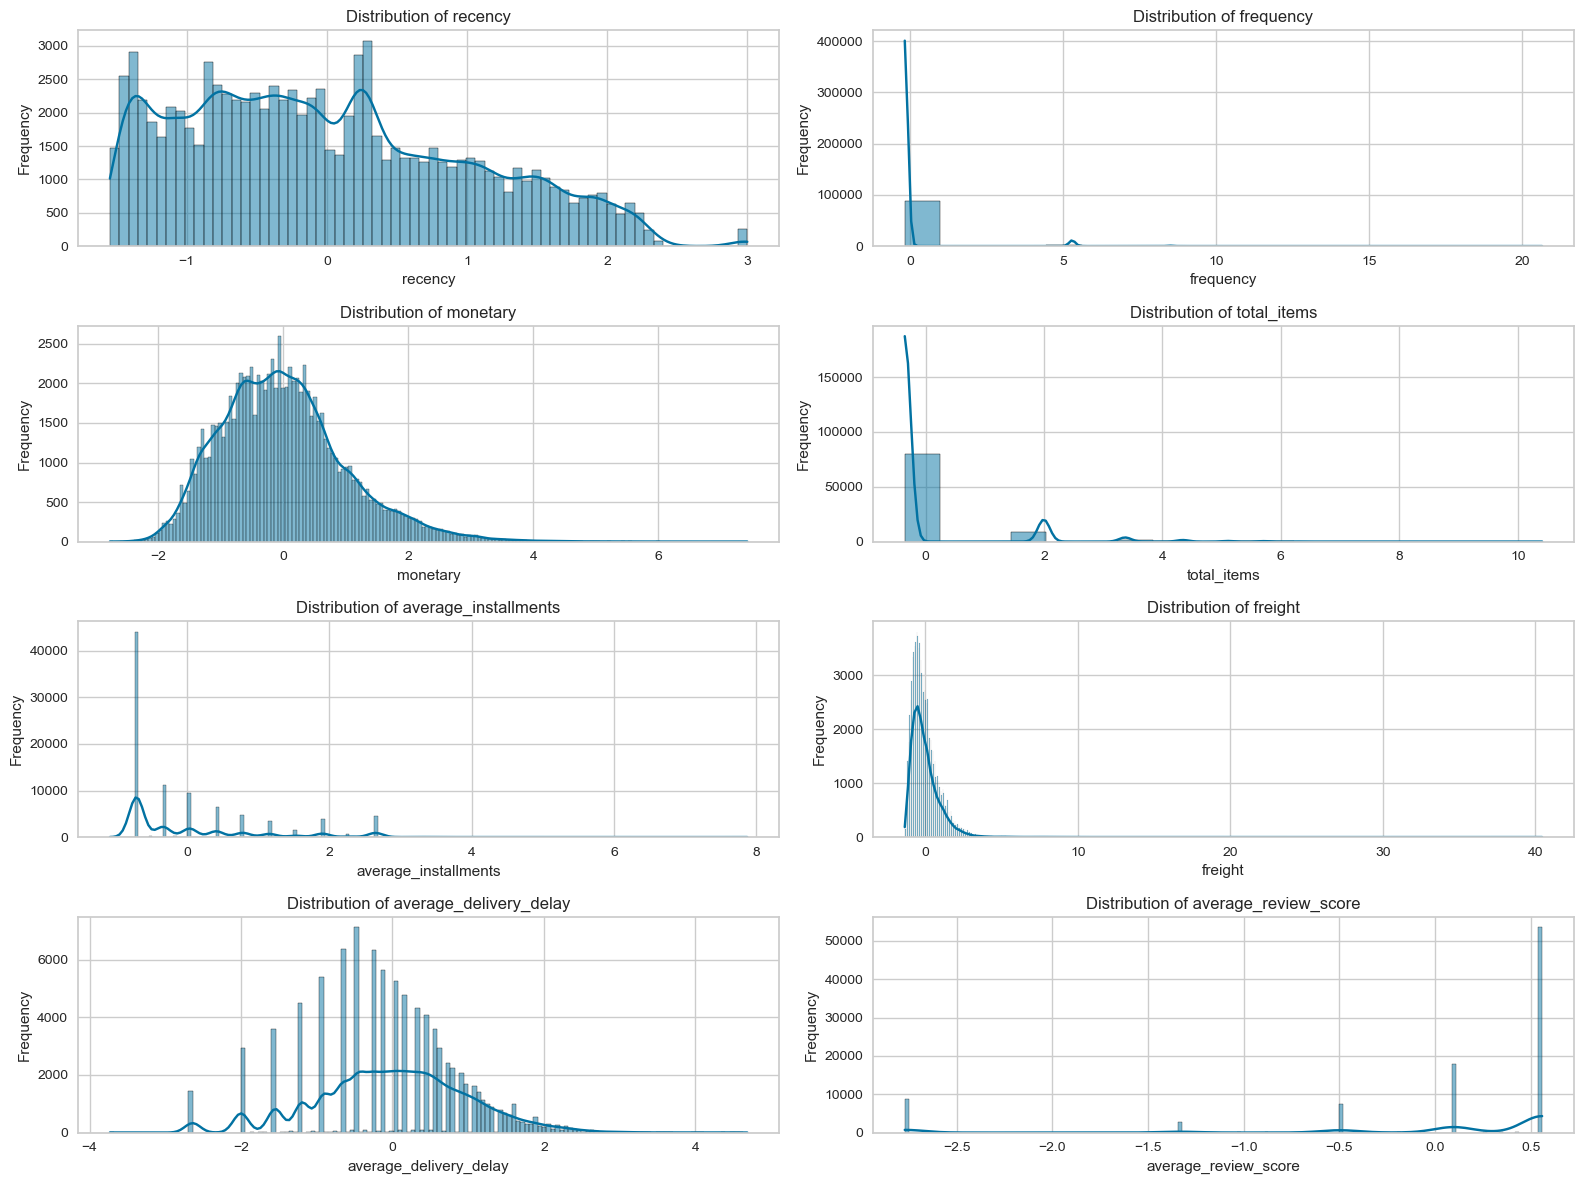

In [19]:
plt.figure(figsize=(16, 12))
for i, var in enumerate(variables, 1):
    plt.subplot(4, 2, i)
    sns.histplot(df_log_scaled[var], kde=True)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## <a name="C4"> Modèle K-means </a>

- Détermination du nombre de clusters

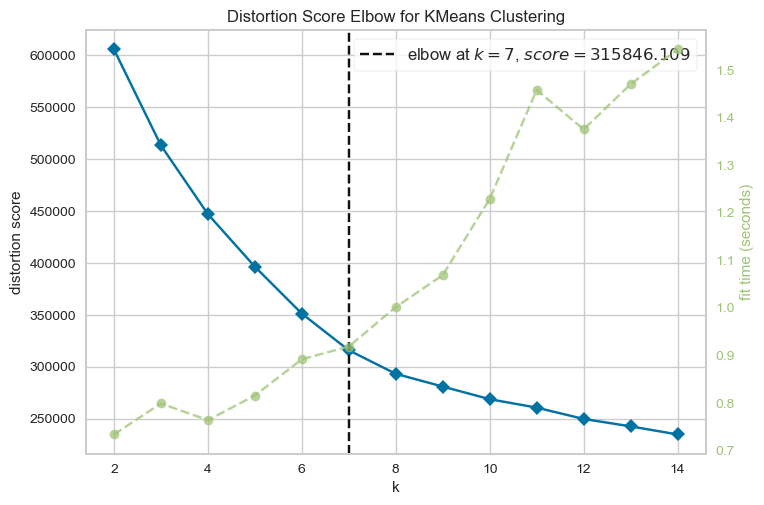

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [20]:
kmeans_model = KMeans(random_state=42, n_init=10)
elbow = KElbowVisualizer(kmeans_model, k=(2,15))

elbow.fit(df_log_scaled) 
elbow.poof() 

- Analyse de la pertinence de 7 clusters

In [21]:
# Calcul du coefficient de silhouette pour 7 clusters
kmeans_7 = KMeans(n_clusters=7, random_state=42, n_init=10)
clusters_7 = kmeans_7.fit_predict(df_log_scaled)
silhouette_avg_7 = silhouette_score(df_log_scaled, clusters_7)
print(f"Coefficient de silhouette pour 7 clusters: {silhouette_avg_7}")

# Calcul de l'indice de Davies-Bouldin pour 7 clusters
kmeans_7 = KMeans(n_clusters=7, random_state=42, n_init=10)
clusters_7 = kmeans_7.fit_predict(df_log_scaled)
davies_bouldin_7 = davies_bouldin_score(df_log_scaled, clusters_7)
print(f"Indice de Davies-Bouldin pour 7 clusters: {davies_bouldin_7}")

# Calcul de l'indice de Calinski-Harabasz pour 7 clusters
kmeans_7 = KMeans(n_clusters=7, random_state=42, n_init=10)
clusters_7 = kmeans_7.fit_predict(df_log_scaled)
calinski_harabasz_7 = calinski_harabasz_score(df_log_scaled, clusters_7)
print(f"Indice de Calinski-Harabasz pour 7 clusters: {calinski_harabasz_7}")

Coefficient de silhouette pour 7 clusters: 0.2090047260328912
Indice de Davies-Bouldin pour 7 clusters: 1.2714181841511307
Indice de Calinski-Harabasz pour 7 clusters: 19927.753727308136


In [22]:
kmeans_7 = KMeans(n_clusters=7, random_state=42, n_init=10)
kmeans_7.fit(df_log_scaled)

KMeans(n_clusters=7, n_init=10, random_state=42)

c:\Users\lokma\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


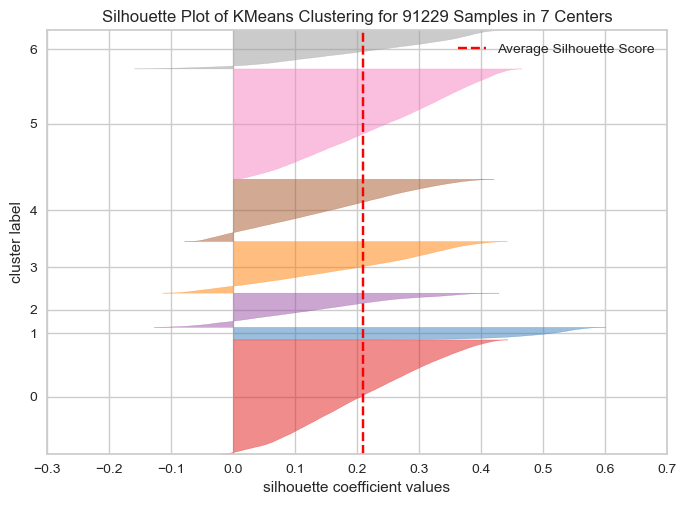

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 91229 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [23]:
visualizer = SilhouetteVisualizer(kmeans_7)

visualizer.fit(df_log_scaled) 
visualizer.poof()

In [24]:
df_log_scaled['cluster_7']= kmeans_7.labels_
df_log_scaled.head()

,recency,frequency,monetary,total_items,average_installments,freight,average_delivery_delay,average_review_score,cluster_7
0,-0.820069,-0.171006,0.167449,-0.351782,1.901885,-0.812589,-0.665971,0.560197,3
1,-0.800415,-0.171006,-1.635981,-0.351782,-0.710068,0.628175,-1.547536,0.098206,5
2,1.964315,-0.171006,-0.376351,-0.351782,1.901885,-0.026718,1.401123,-0.497405,3
3,0.549193,-0.171006,-1.120073,-0.351782,0.409340,1.283068,1.064678,0.098206,4
4,0.332993,-0.171006,0.524934,-0.351782,1.155613,-0.747100,0.425947,0.560197,3


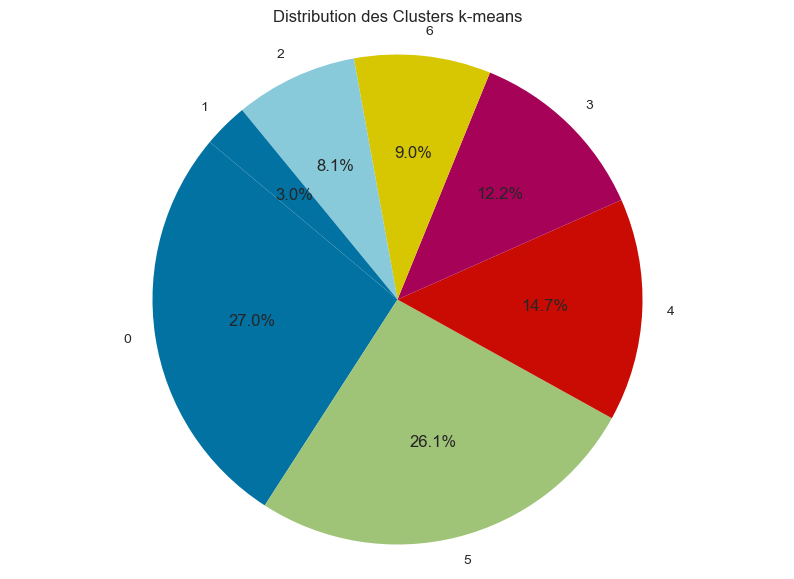

In [25]:
segment_counts = df_log_scaled['cluster_7'].value_counts()

plt.figure(figsize=(10, 7))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution des Clusters k-means')
plt.axis('equal')  
plt.show()

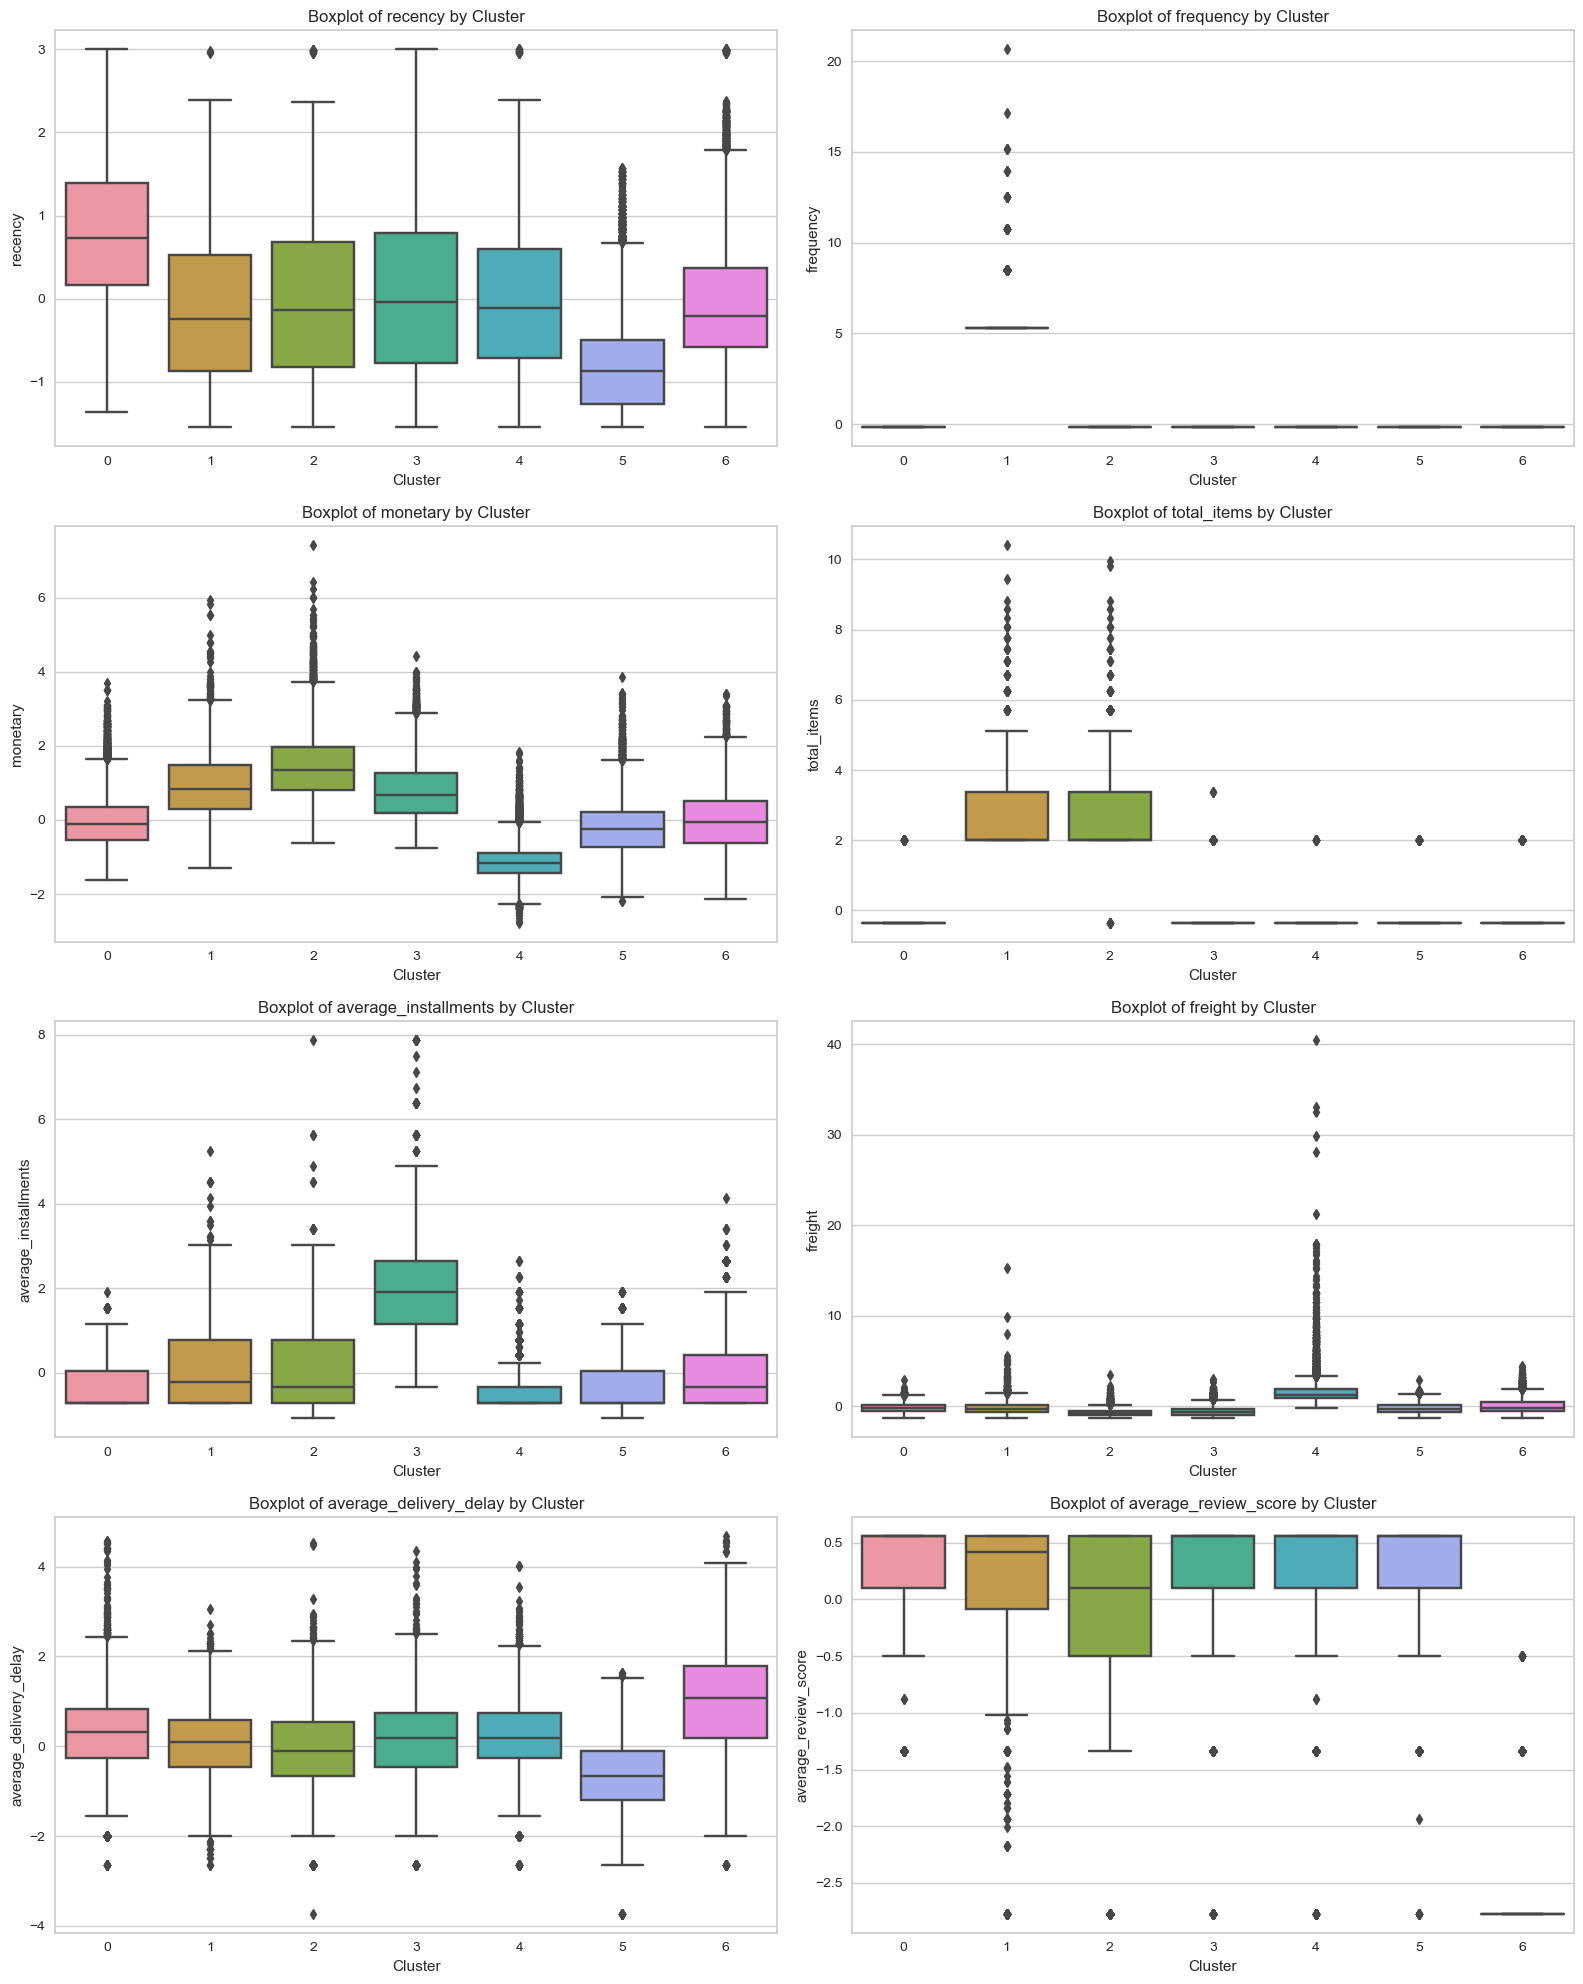

In [26]:
variables = ['recency', 'frequency', 'monetary', 'total_items', 
             'average_installments', 'freight', 
             'average_delivery_delay', 'average_review_score']

plt.figure(figsize=(16, 20))
for i, var in enumerate(variables, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(x='cluster_7', y=var, data=df_log_scaled)
    plt.title(f'Boxplot of {var} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(var)

plt.tight_layout()
plt.show()

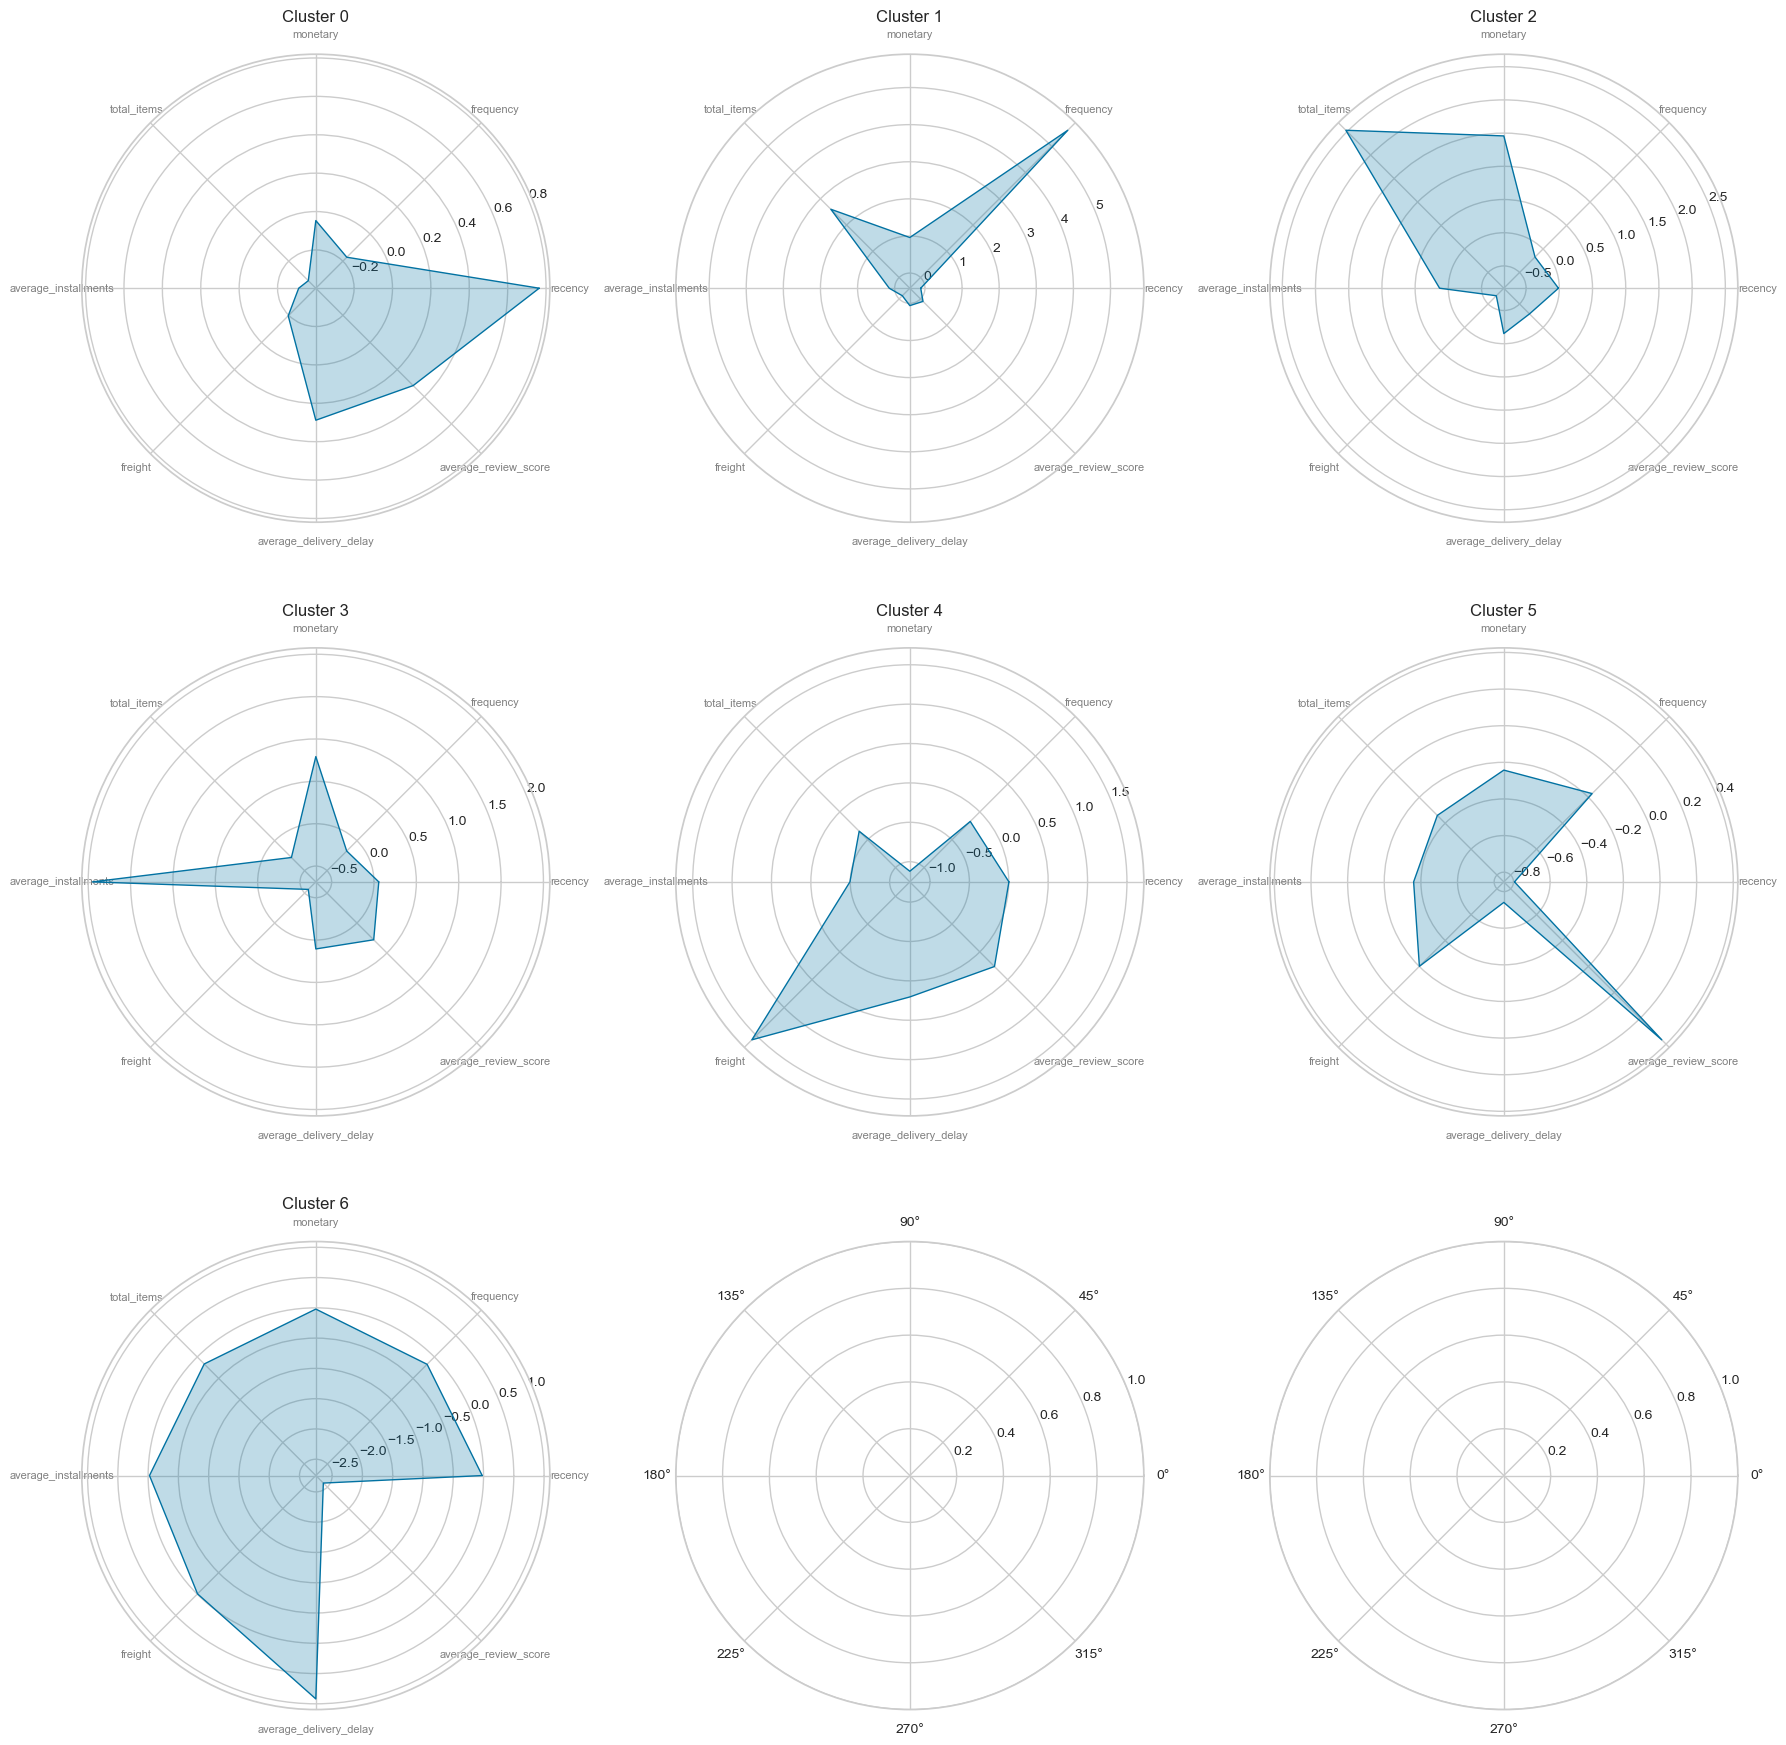

In [27]:
from math import pi

variables = ['recency', 'frequency', 'monetary', 'total_items', 
             'average_installments', 'freight', 
             'average_delivery_delay', 'average_review_score']

cluster_means = df_log_scaled.groupby('cluster_7')[variables].mean().reset_index()

num_clusters = len(cluster_means)

def create_radar_charts(cluster_means, variables):
    num_vars = len(variables)
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]

    fig, axs = plt.subplots(3, 3, figsize=(18, 18), subplot_kw=dict(polar=True))
    axs = axs.flatten()

    for i in range(num_clusters):
        values = cluster_means.loc[i].drop('cluster_7').values.flatten().tolist()
        values += values[:1]

        axs[i].plot(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {i}')
        axs[i].fill(angles, values, alpha=0.25)
        axs[i].set_xticks(angles[:-1])
        axs[i].set_xticklabels(variables, color='grey', size=8)
        axs[i].set_title(f'Cluster {i}')

    plt.tight_layout()
    plt.show()

create_radar_charts(cluster_means, variables)

Cluster 0 : Clients peu actifs mais satisfaits.  
Cluster 1 : Clients rares avec dépenses moyennes et paiements par tranches.  
Cluster 2 : Clients très peu actifs avec faible valeur.  
Cluster 3 : Clients moyennement actifs avec dépenses moyennes.  
Cluster 4 : Clients rares avec dépenses moyennes et coûts de fret élevés.  
Cluster 5 : Clients très peu actifs et peu dépensiers.  
Cluster 6 : Clients récents mais rares, avec des avis positifs et des dépenses moyennes.  

L'analyse métier de ce clustering n'est pas pertinent, nous faisons une tentative avec 5 clusters.

- Analyse de la pertinence de 5 clusters

In [28]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

# Calcul du coefficient de silhouette pour 5 clusters
kmeans_5 = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters_5 = kmeans_5.fit_predict(df_log_scaled)
silhouette_avg_5 = silhouette_score(df_log_scaled, clusters_5)
print(f"Coefficient de silhouette pour 5 clusters: {silhouette_avg_5}")

# Calcul de l'indice de Davies-Bouldin pour 5 clusters
kmeans_5 = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters_5 = kmeans_5.fit_predict(df_log_scaled)
davies_bouldin_5 = davies_bouldin_score(df_log_scaled, clusters_5)
print(f"Indice de Davies-Bouldin pour 5 clusters: {davies_bouldin_5}")

# Calcul de l'indice de Calinski-Harabasz pour 5 clusters
kmeans_5 = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters_5 = kmeans_5.fit_predict(df_log_scaled)
calinski_harabasz_5 = calinski_harabasz_score(df_log_scaled, clusters_5)
print(f"Indice de Calinski-Harabasz pour 5 clusters: {calinski_harabasz_5}")

Coefficient de silhouette pour 5 clusters: 0.4041141091529295
Indice de Davies-Bouldin pour 5 clusters: 1.1302564624764262
Indice de Calinski-Harabasz pour 5 clusters: 38427.25498241504


In [29]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans.fit(df_log_scaled)

KMeans(n_clusters=5, n_init=10, random_state=42)

c:\Users\lokma\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


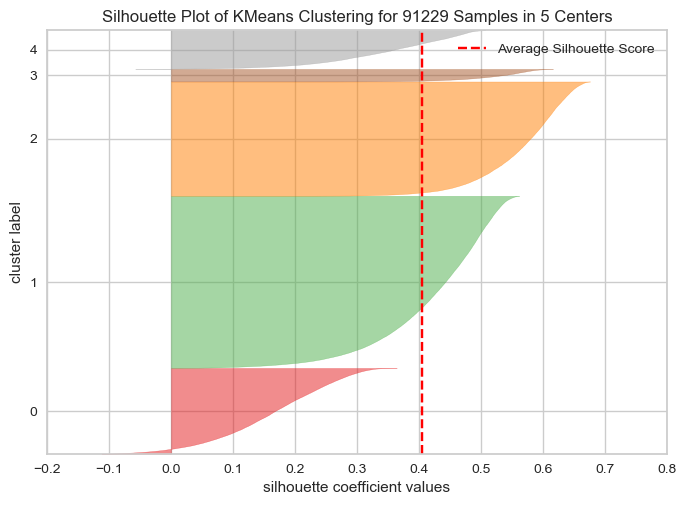

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 91229 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [30]:
visualizer = SilhouetteVisualizer(kmeans)

visualizer.fit(df_log_scaled) 
visualizer.poof()

In [31]:
df_log_scaled['cluster']= kmeans.labels_
df_log_scaled.head()

,recency,frequency,monetary,total_items,average_installments,freight,average_delivery_delay,average_review_score,cluster_7,cluster
0,-0.820069,-0.171006,0.167449,-0.351782,1.901885,-0.812589,-0.665971,0.560197,3,0
1,-0.800415,-0.171006,-1.635981,-0.351782,-0.710068,0.628175,-1.547536,0.098206,5,1
2,1.964315,-0.171006,-0.376351,-0.351782,1.901885,-0.026718,1.401123,-0.497405,3,0
3,0.549193,-0.171006,-1.120073,-0.351782,0.409340,1.283068,1.064678,0.098206,4,1
4,0.332993,-0.171006,0.524934,-0.351782,1.155613,-0.747100,0.425947,0.560197,3,0


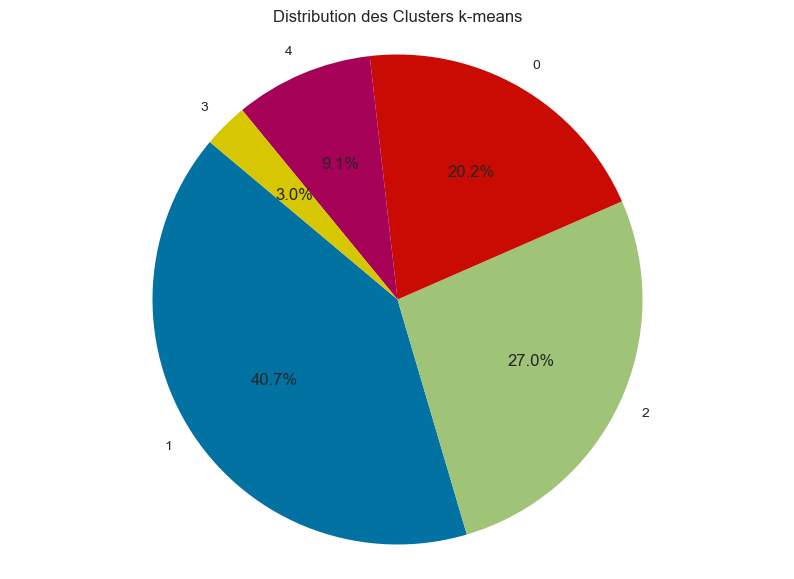

In [32]:
segment_counts = df_log_scaled['cluster'].value_counts()

plt.figure(figsize=(10, 7))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution des Clusters k-means')
plt.axis('equal')  
plt.show()

- Analyse des clusters

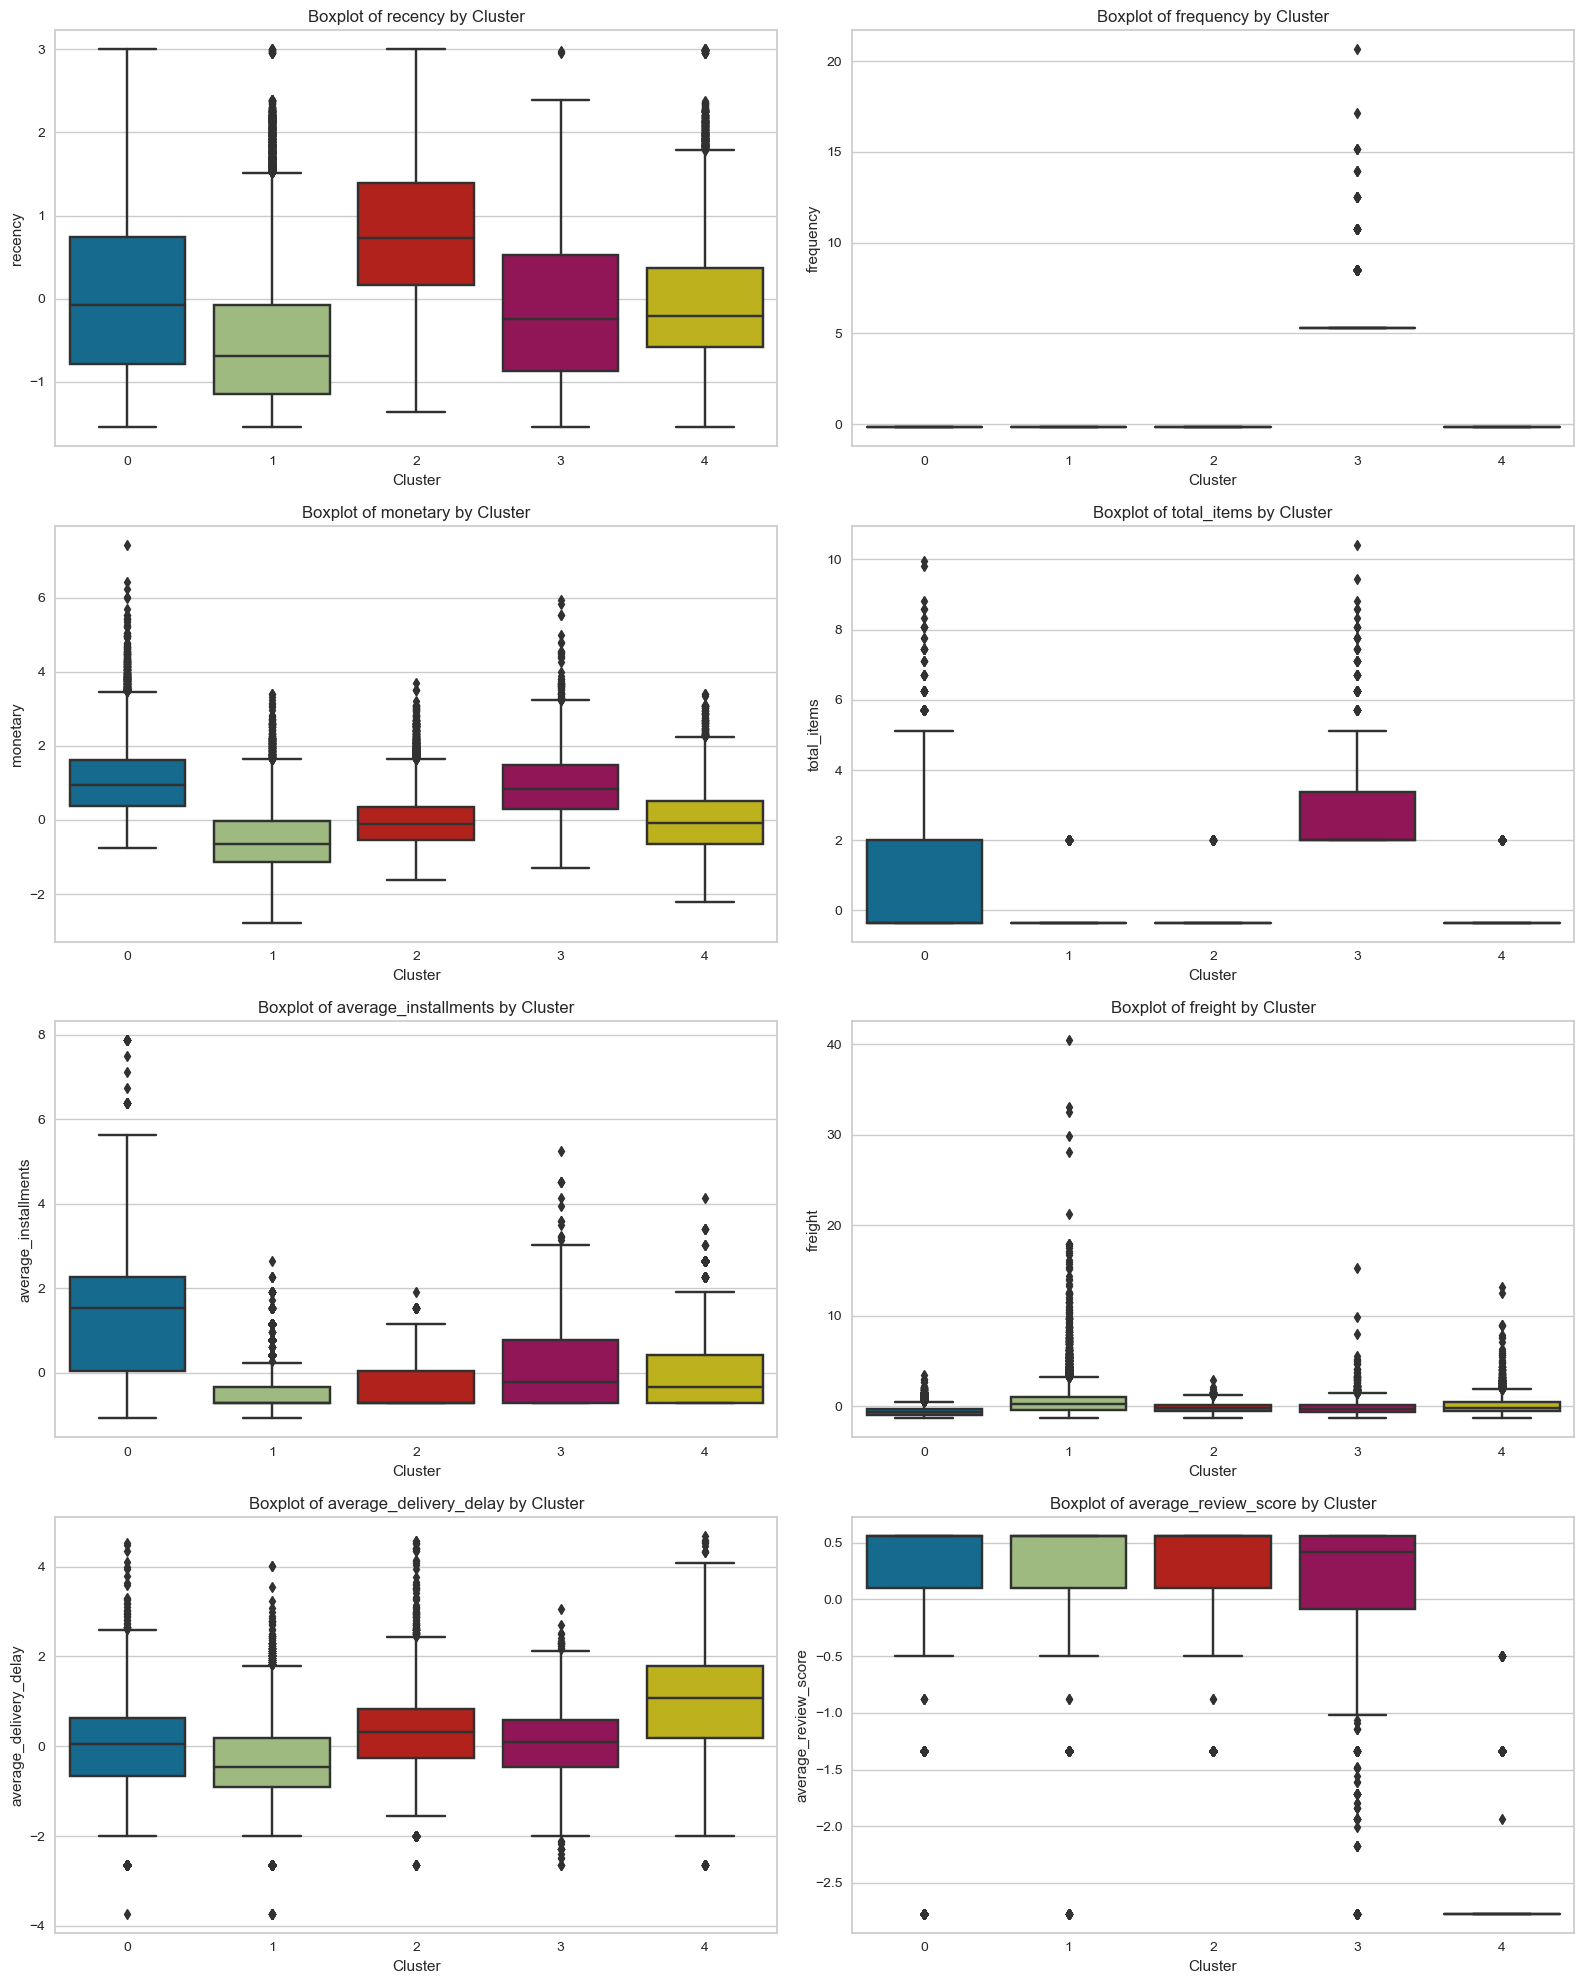

In [33]:
variables = ['recency', 'frequency', 'monetary', 'total_items', 
             'average_installments', 'freight', 
             'average_delivery_delay', 'average_review_score']

plt.figure(figsize=(16, 20))
for i, var in enumerate(variables, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(x='cluster', y=var, data=df_log_scaled)
    plt.title(f'Boxplot of {var} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(var)

plt.tight_layout()
plt.show()

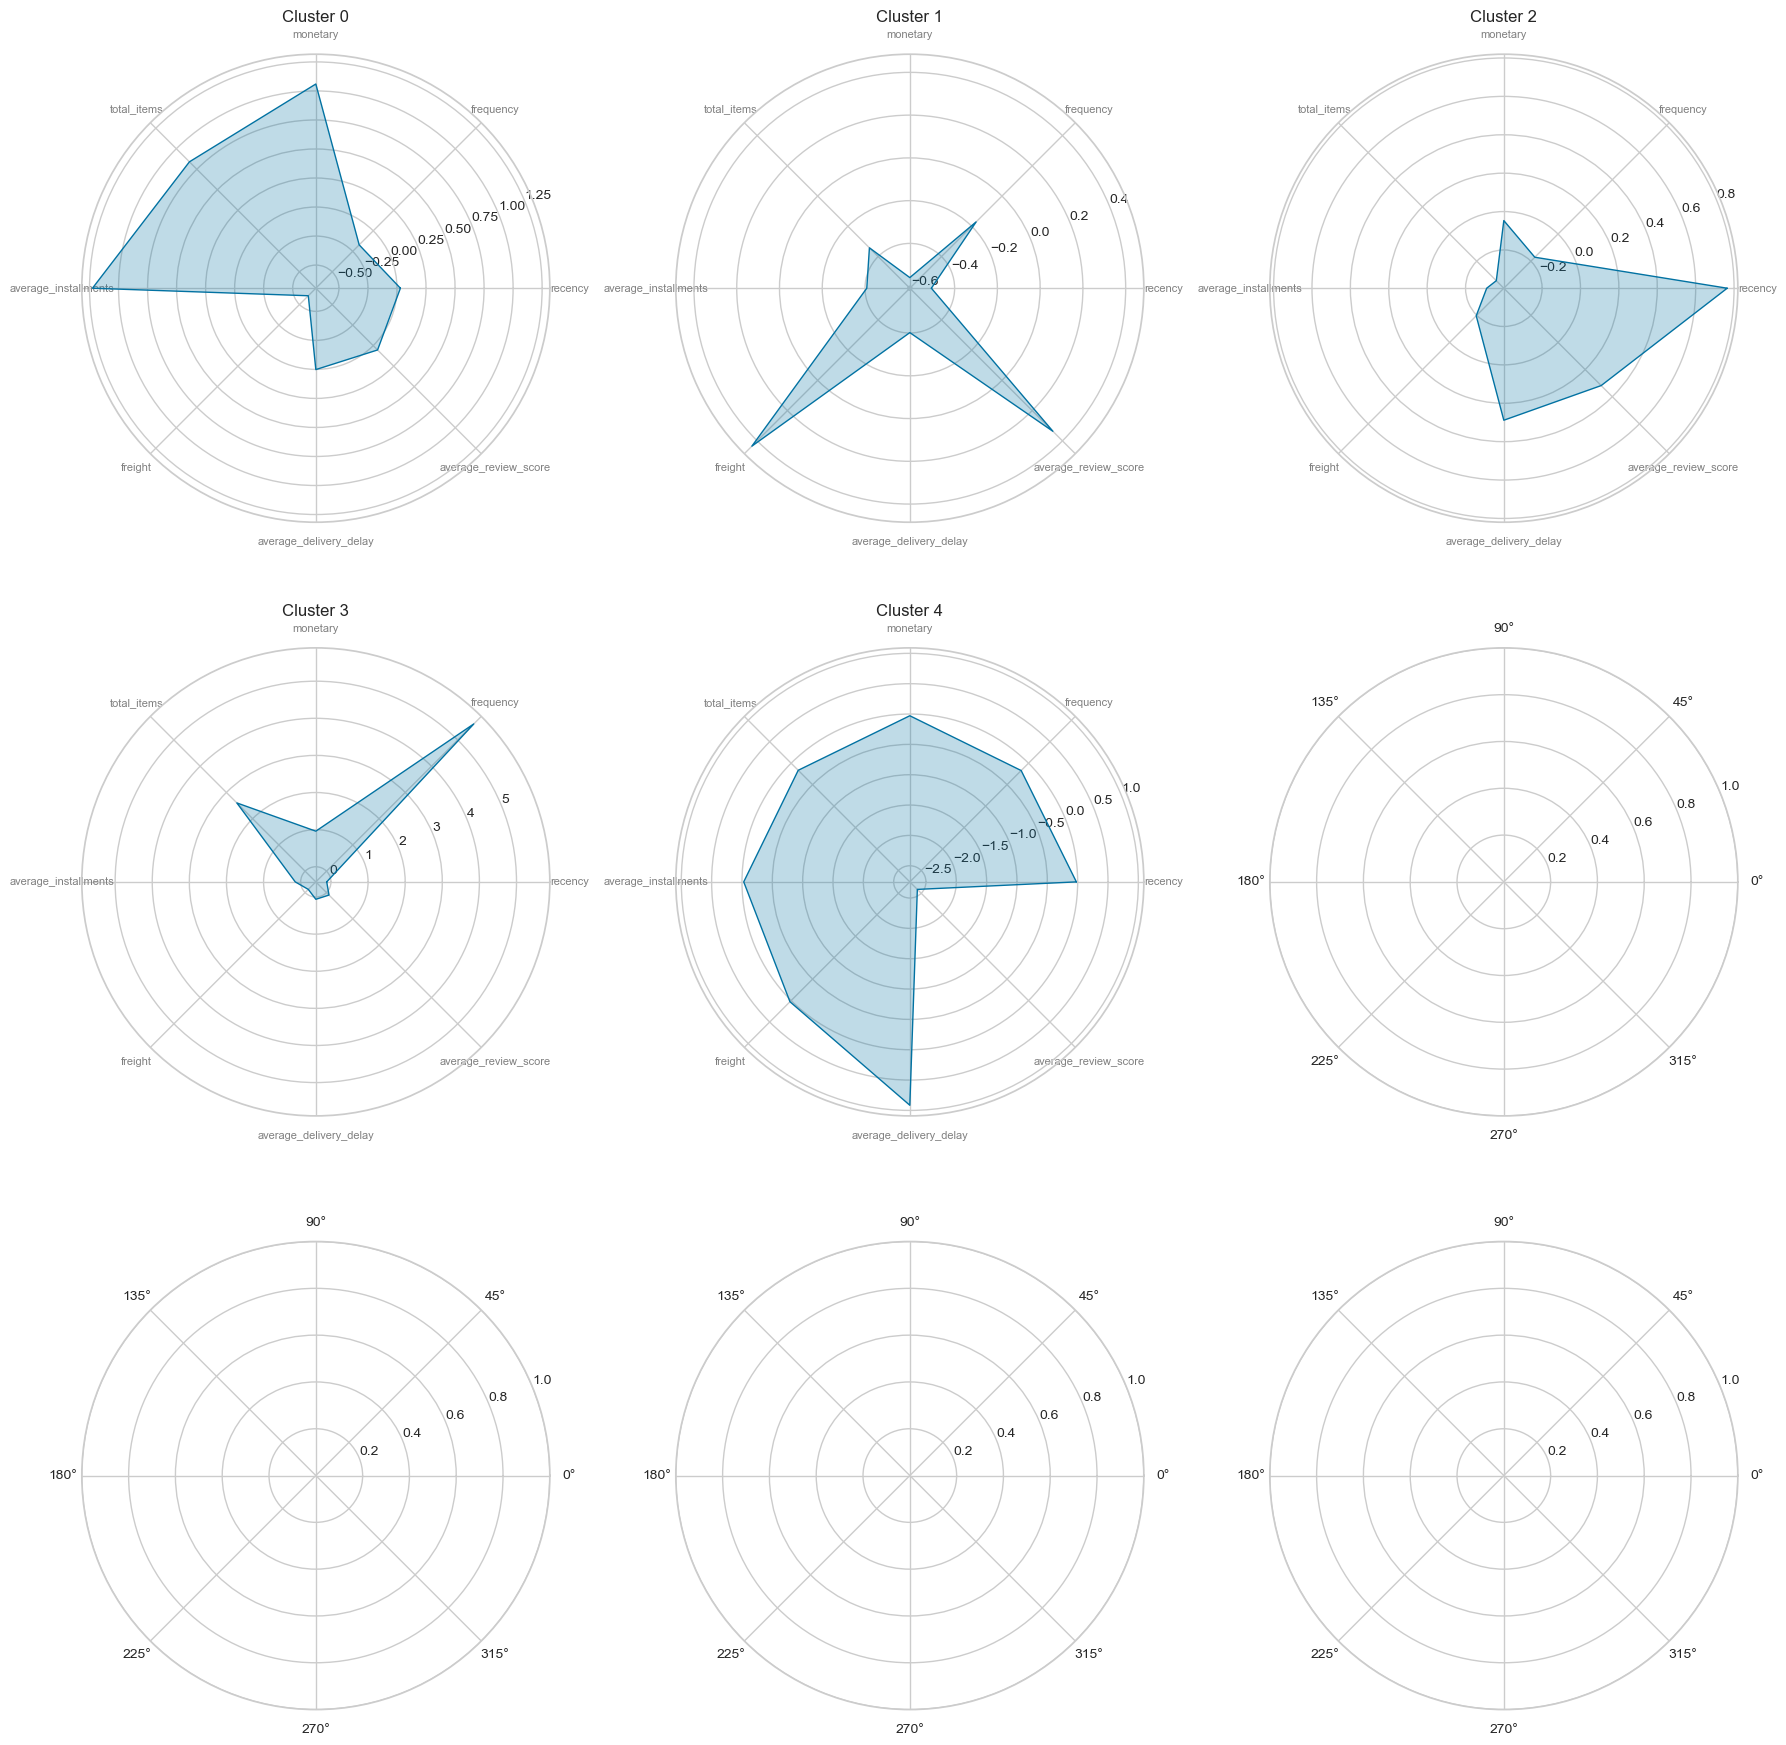

In [34]:
from math import pi

# Calculer les moyennes des variables par cluster
variables = ['recency', 'frequency', 'monetary', 'total_items', 
             'average_installments', 'freight', 
             'average_delivery_delay', 'average_review_score']

cluster_means = df_log_scaled.groupby('cluster')[variables].mean().reset_index()

# Nombre de clusters
num_clusters = len(cluster_means)

# Créer un radar plot pour chaque cluster
def create_radar_charts(cluster_means, variables):
    # Nombre de variables
    num_vars = len(variables)

    # Angles pour chaque variable
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]

    # Initialiser le radar plot
    fig, axs = plt.subplots(3, 3, figsize=(18, 18), subplot_kw=dict(polar=True))
    axs = axs.flatten()

    for i in range(num_clusters):
        values = cluster_means.loc[i].drop('cluster').values.flatten().tolist()
        values += values[:1]

        # Tracer les valeurs pour le cluster
        axs[i].plot(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {i}')
        axs[i].fill(angles, values, alpha=0.25)

        # Ajouter les labels pour chaque angle
        axs[i].set_xticks(angles[:-1])
        axs[i].set_xticklabels(variables, color='grey', size=8)

        # Ajouter un titre
        axs[i].set_title(f'Cluster {i}')

    # Ajuster l'affichage
    plt.tight_layout()
    plt.show()

# Créer et afficher les radar plots dans le même visuel
create_radar_charts(cluster_means, variables)


Cluster 0 : Ce cluster montre une forte valeur pour le chiffre d'affaires total et la fréquence d'achat, mais des scores moyens pour les délais de livraison et les avis.  
Cluster 1 : Caractérisé par une forte variabilité avec des valeurs élevées dans la fréquence d'achat et les notes d'avis, mais faible en chiffre d'affaires total et délais de livraison.  
Cluster 2 : Démontre une contribution notable en chiffre d'affaires total et avis moyens, mais faible en fréquence d'achat et délais de livraison.  
Cluster 3 : Affiche une performance élevée dans les délais de livraison et un chiffre d'affaires total modeste, mais une fréquence d'achat faible et des avis moyens.  
Cluster 4 : Possède des valeurs équilibrées dans toutes les dimensions, avec une performance légèrement supérieure en termes de chiffre d'affaires total et d'avis.  

Cluster 0 : Clients fidèles et dépensiers  
Cluster 1 : Clients réguliers avec des avis positifs  
Cluster 2 : Clients occasionnels avec des avis moyens  
Cluster 3 : Clients sensibles aux délais de livraison longs  
Cluster 4 : Clients insatisfaits

- Analyse du Chiffre d'affaires

In [35]:
clusters = df_log_scaled.copy() 
clusters = clusters[['cluster']]

clusters = clusters.reset_index()
df = df.reset_index()

df_with_clusters = pd.merge(df, clusters, left_index=True, right_index=True, how='inner')
df_with_clusters = df_with_clusters.drop(columns=['index'])

df_with_clusters

,customer_unique_id,recency,frequency,monetary,total_items,average_installments,freight,average_delivery_delay,average_review_score,cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90,1,8.0,0.08,6.0,5.0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19,1,1.0,0.30,3.0,4.0,1
2,0000f46a3911fa3c0805444483337064,538,1,86.22,1,8.0,0.20,25.0,3.0,0
3,0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62,1,4.0,0.40,20.0,4.0,1
4,0004aac84e0df4da2b147fca70cf8255,289,1,196.89,1,6.0,0.09,13.0,5.0,0
...,...,...,...,...,...,...,...,...,...,...
91224,fffcf5a5ff07b0908bd4e2dbc735a684,448,1,4134.84,2,10.0,0.12,27.0,5.0,0
91225,fffea47cd6d3cc0a88bd621562a9d061,263,1,84.58,1,1.0,0.23,30.0,4.0,2
91226,ffff371b4d645b6ecea244b27531430a,569,1,112.46,1,1.0,0.20,14.0,5.0,2
91227,ffff5962728ec6157033ef9805bacc48,120,1,133.69,1,5.0,0.14,11.0,5.0,1


In [36]:
df

,customer_unique_id,recency,frequency,monetary,total_items,average_installments,freight,average_delivery_delay,average_review_score
0,0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90,1,8.0,0.08,6.0,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19,1,1.0,0.30,3.0,4.0
2,0000f46a3911fa3c0805444483337064,538,1,86.22,1,8.0,0.20,25.0,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62,1,4.0,0.40,20.0,4.0
4,0004aac84e0df4da2b147fca70cf8255,289,1,196.89,1,6.0,0.09,13.0,5.0
...,...,...,...,...,...,...,...,...,...
91224,fffcf5a5ff07b0908bd4e2dbc735a684,448,1,4134.84,2,10.0,0.12,27.0,5.0
91225,fffea47cd6d3cc0a88bd621562a9d061,263,1,84.58,1,1.0,0.23,30.0,4.0
91226,ffff371b4d645b6ecea244b27531430a,569,1,112.46,1,1.0,0.20,14.0,5.0
91227,ffff5962728ec6157033ef9805bacc48,120,1,133.69,1,5.0,0.14,11.0,5.0


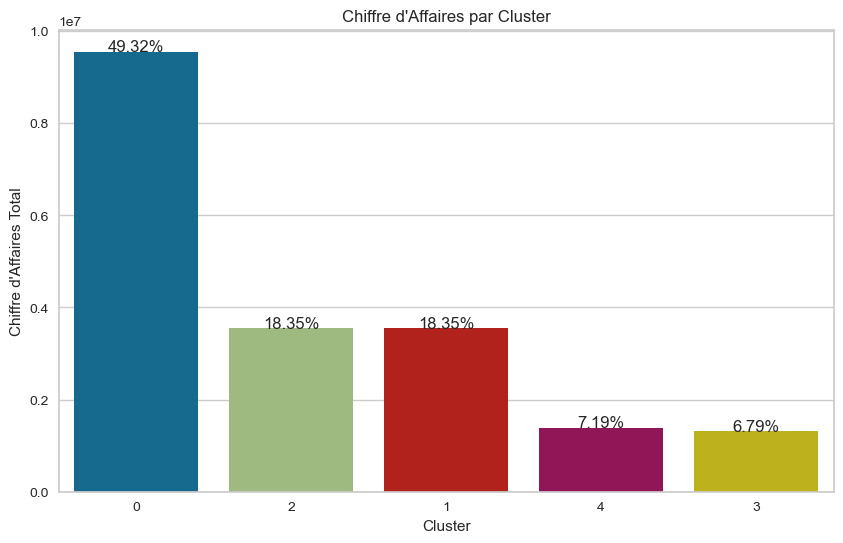

In [37]:
revenue_per_cluster = df_with_clusters.groupby('cluster')['monetary'].sum().reset_index()
revenue_per_cluster.columns = ['cluster', 'total_revenue']

total_revenue = revenue_per_cluster['total_revenue'].sum()

revenue_per_cluster['revenue_percentage'] = (revenue_per_cluster['total_revenue'] / total_revenue) * 100
revenue_per_cluster = revenue_per_cluster.sort_values(by='total_revenue', ascending=False)

plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='cluster', y='total_revenue', data=revenue_per_cluster, order=revenue_per_cluster['cluster'])
plt.title('Chiffre d\'Affaires par Cluster')
plt.xlabel('Cluster')
plt.ylabel('Chiffre d\'Affaires Total')

for i in range(len(revenue_per_cluster)):
    plt.text(i, revenue_per_cluster['total_revenue'].values[i], f"{revenue_per_cluster['revenue_percentage'].values[i]:.2f}%", ha='center')
    
plt.show()

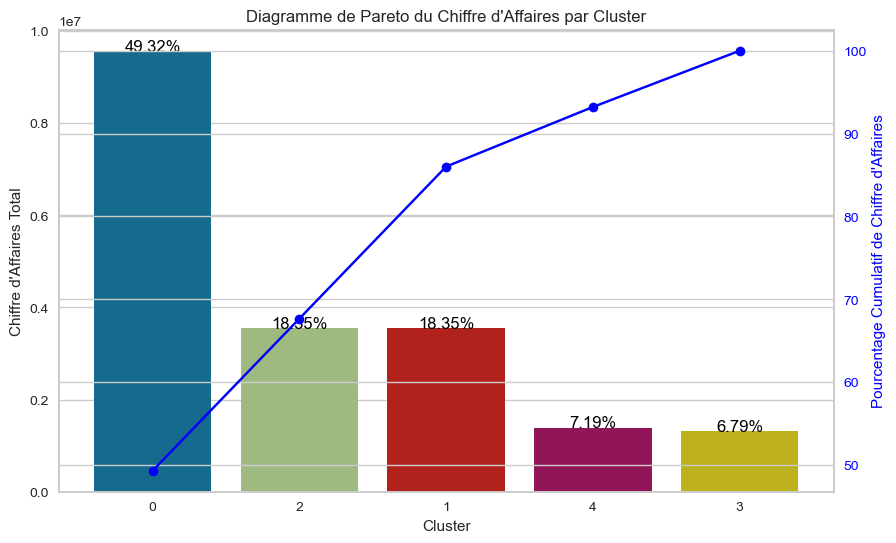

In [38]:
revenue_per_cluster = df_with_clusters.groupby('cluster')['monetary'].sum().reset_index()
revenue_per_cluster.columns = ['cluster', 'total_revenue']

revenue_per_cluster = revenue_per_cluster.sort_values(by='total_revenue', ascending=False).reset_index(drop=True)
total_revenue = revenue_per_cluster['total_revenue'].sum()

revenue_per_cluster['revenue_percentage'] = (revenue_per_cluster['total_revenue'] / total_revenue) * 100
revenue_per_cluster['cumulative_percentage'] = revenue_per_cluster['revenue_percentage'].cumsum()
revenue_per_cluster = revenue_per_cluster.sort_values(by='total_revenue', ascending=False)

revenue_per_cluster['cluster'] = pd.Categorical(revenue_per_cluster['cluster'],
                                                categories=revenue_per_cluster['cluster'],
                                                ordered=True)

fig, ax1 = plt.subplots(figsize=(10, 6))
sns.barplot(x='cluster', y='total_revenue', data=revenue_per_cluster, ax=ax1)
ax1.set_title('Diagramme de Pareto du Chiffre d\'Affaires par Cluster')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Chiffre d\'Affaires Total')

for index, row in revenue_per_cluster.iterrows():
    ax1.text(row.name, row.total_revenue, f'{row.revenue_percentage:.2f}%', color='black', ha="center")

ax2 = ax1.twinx()
ax2.plot( revenue_per_cluster['cumulative_percentage'], color='blue', marker='o', linestyle='-')
ax2.set_ylabel('Pourcentage Cumulatif de Chiffre d\'Affaires', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.show()

Concentration des Revenus : Une part importante du chiffre d'affaires est générée par le Cluster 0. Les efforts pour maximiser les revenus devraient être concentrés sur ce cluster.  
Principe de Pareto : Les 2 premiers clusters (0 et 2) suivent le principe de Pareto, générant la majorité du chiffre d'affaires avec un petit nombre de clusters.  
Analyse des Moins Performants : Les Clusters 3 et 4 ont une contribution marginale.

## <a name="C4"> Algorithme DBSCAN </a>

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) est un algorithme de clustering non supervisé qui regroupe des points de données proches en fonction de leur densité et identifie les points isolés comme du bruit.

- Sampling

In [39]:
df_dbscan = df_log_scaled.copy()
df_dbscan_sampled = df_dbscan.sample(n=20000, random_state=0)

- Sélection des hyperparamètres

In [40]:
param_grid = {'eps': [0.1, 0.3, 0.5, 0.7, 0.85, 1], 'min_samples': [5, 10, 15, 20, 25, 30]}

best_params = None
best_silhouette_score = -1  

for params in ParameterGrid(param_grid):
    dbscan = DBSCAN(**params)
    dbscan_labels = dbscan.fit_predict(df_dbscan_sampled)
    unique_labels, counts = np.unique(dbscan_labels, return_counts=True)
    if len(unique_labels) > 1:  # Au moins un cluster autre que le bruit
        silhouette_avg = silhouette_score(df_dbscan_sampled, dbscan_labels)
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_params = params

print("Hyperparamètres sélectionnés:", best_params)

Hyperparamètres sélectionnés: {'eps': 1, 'min_samples': 25}


In [41]:
dbscan = DBSCAN(eps= 1, min_samples= 25)
dbscan.fit(df_dbscan_sampled)
cluster_labels = dbscan.labels_

In [42]:
unique_labels = np.unique(cluster_labels[cluster_labels != -1])
num_clusters = len(unique_labels)

print("Number of clusters obtained:", num_clusters)

Number of clusters obtained: 9


- Evaluation

In [43]:
silhouette_dbscan = silhouette_score(df_dbscan_sampled, cluster_labels)
print('Silhouette :', silhouette_dbscan)

calinski_harabasz_dbscan = calinski_harabasz_score(df_dbscan_sampled, cluster_labels)
print('Calinski Harabasz :', calinski_harabasz_dbscan)

davies_bouldin_dbscan = davies_bouldin_score(df_dbscan_sampled, cluster_labels)
print('Davies Bouldin :',  davies_bouldin_dbscan)

Silhouette : 0.30014507170578497
Calinski Harabasz : 3661.8518531772665
Davies Bouldin : 1.7778837742160885


- Affichage des clusters DBSCAN

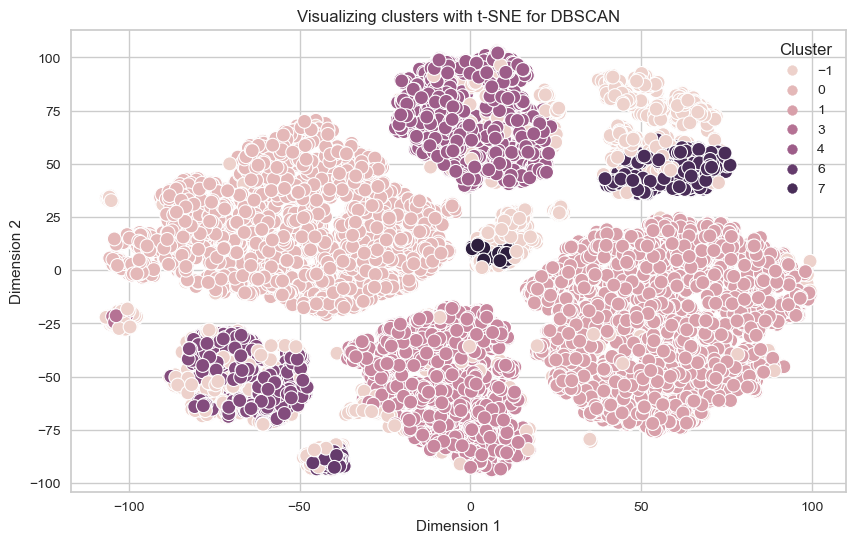

In [44]:
dbscan = TSNE(n_components=2, random_state=0)
dbscan_data = dbscan.fit_transform(df_dbscan_sampled)
dbscan_df = pd.DataFrame({'Dimension 1': dbscan_data[:, 0], 'Dimension 2': dbscan_data[:, 1], 'Cluster': cluster_labels})

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Cluster', data=dbscan_df, s=100)
plt.title('Visualizing clusters with t-SNE for DBSCAN')
plt.show()

- Estimation du bruit

In [45]:
n_noise_ = list(cluster_labels).count(-1)
print('Estimated number of noise points:', n_noise_)

Estimated number of noise points: 2388


Ce graphique représente une visualisation des clusters formés par l'algorithme DBSCAN, réduits à deux dimensions à l'aide de t-SNE. On observe plusieurs clusters distincts, chacun étant bien séparé, ce qui indique que DBSCAN a réussi à identifier des groupes de points de données avec des densités similaires, tandis que les points marqués comme "-1" sont considérés comme du bruit ou des outliers.

## <a name="C4"> Classification Ascendante Hiérarchique </a>

- Création du modèle CAH

In [55]:
df_cah=df.copy()
df_cah = df_cah.sample(n=20000, random_state=0)
df_cah=df_cah.set_index('customer_unique_id')
df_cah = df_cah.apply(np.log1p)
df_cah.head(1)

,recency,frequency,monetary,total_items,average_installments,freight,average_delivery_delay,average_review_score
customer_unique_id,,,,,,,,
a7444a1b286273cf58c731ab0903882b,135,1,81.5,1,1.0,0.17,10.0,4.0


In [68]:
variables = df_cah.values
liste_id = df_cah.index

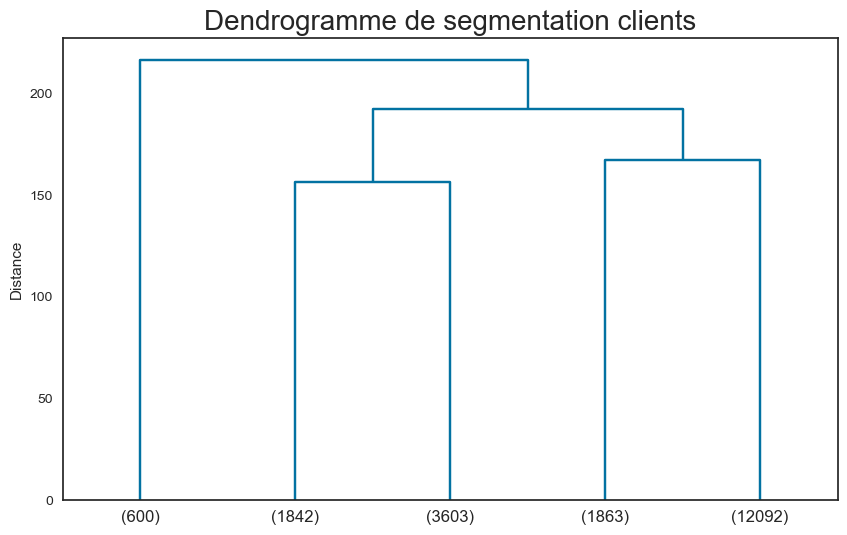

In [69]:
from sklearn import preprocessing

variables_standard = preprocessing.StandardScaler().fit(variables)
variables_echelle = variables_standard.transform(variables)

from scipy.cluster.hierarchy import linkage, fcluster

link_variables = linkage(variables_echelle, method = 'ward', metric='euclidean')

from scipy.cluster.hierarchy import dendrogram

fig =plt.figure(figsize=(10,6))
sns.set_style('white')
plt.title('Dendrogramme de segmentation clients', fontsize=20)
plt.ylabel('Distance')
dendrogram(link_variables, labels = df_cah.index, p=5, truncate_mode='lastp', orientation='top')
plt.show()

- Analyse des clusters du modèle

In [70]:
classe = fcluster(link_variables, t=5, criterion='maxclust')
df_final_cah = pd.DataFrame({'customer_unique_id' : df_cah.index.tolist(),
                             'classe' : classe})
df_final_cah = df_final_cah.sort_values(['classe', 'customer_unique_id'])

df_final_cah = pd.merge(df_cah, df_final_cah, on='customer_unique_id')
df_final_cah.head(1)

,customer_unique_id,recency,frequency,monetary,total_items,average_installments,freight,average_delivery_delay,average_review_score,classe
0,a7444a1b286273cf58c731ab0903882b,4.912655,0.693147,4.412798,0.693147,0.693147,0.157004,2.397895,1.609438,5


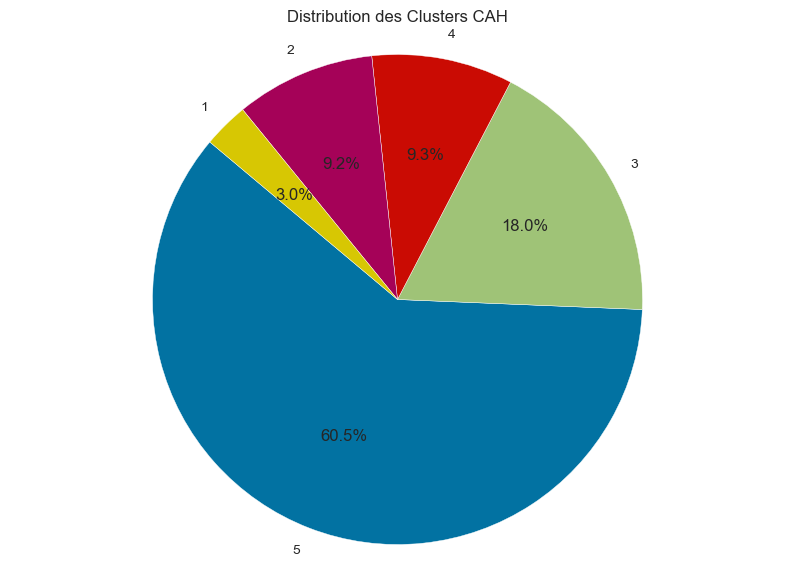

In [71]:
segment_counts = df_final_cah['classe'].value_counts()

plt.figure(figsize=(10, 7))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution des Clusters CAH')
plt.axis('equal')  
plt.show()

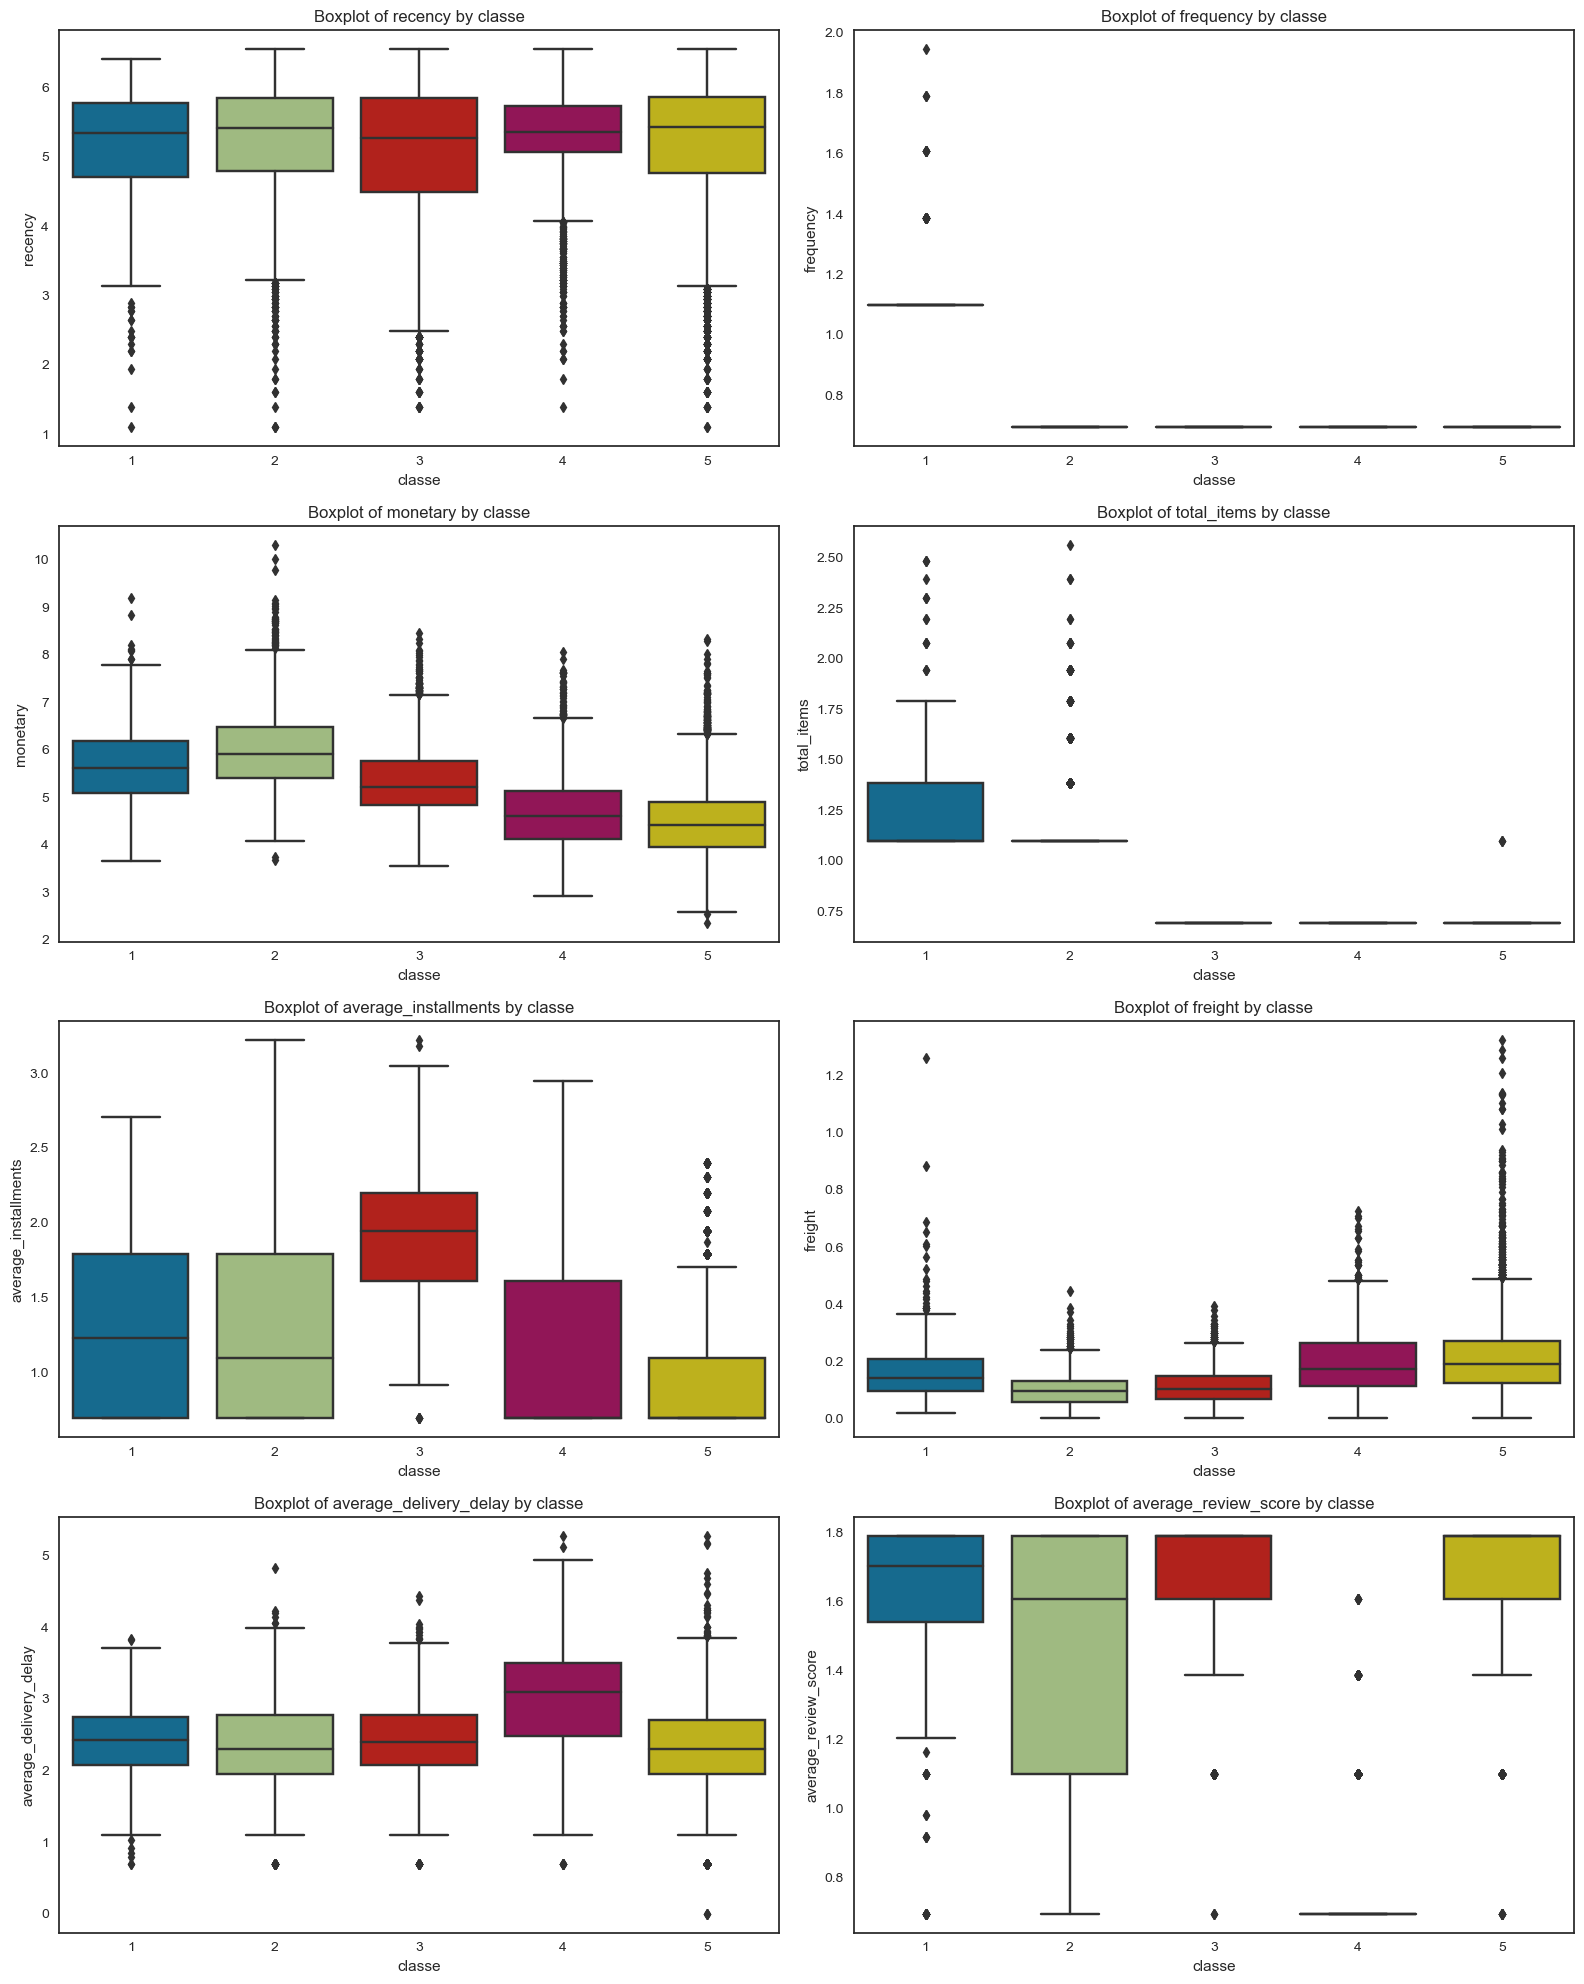

In [72]:
variables = ['recency', 'frequency', 'monetary', 'total_items', 
             'average_installments', 'freight', 
             'average_delivery_delay', 'average_review_score']

plt.figure(figsize=(16, 20))
for i, var in enumerate(variables, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(x='classe', y=var, data=df_final_cah)
    plt.title(f'Boxplot of {var} by classe')
    plt.xlabel('classe')
    plt.ylabel(var)

plt.tight_layout()
plt.show()

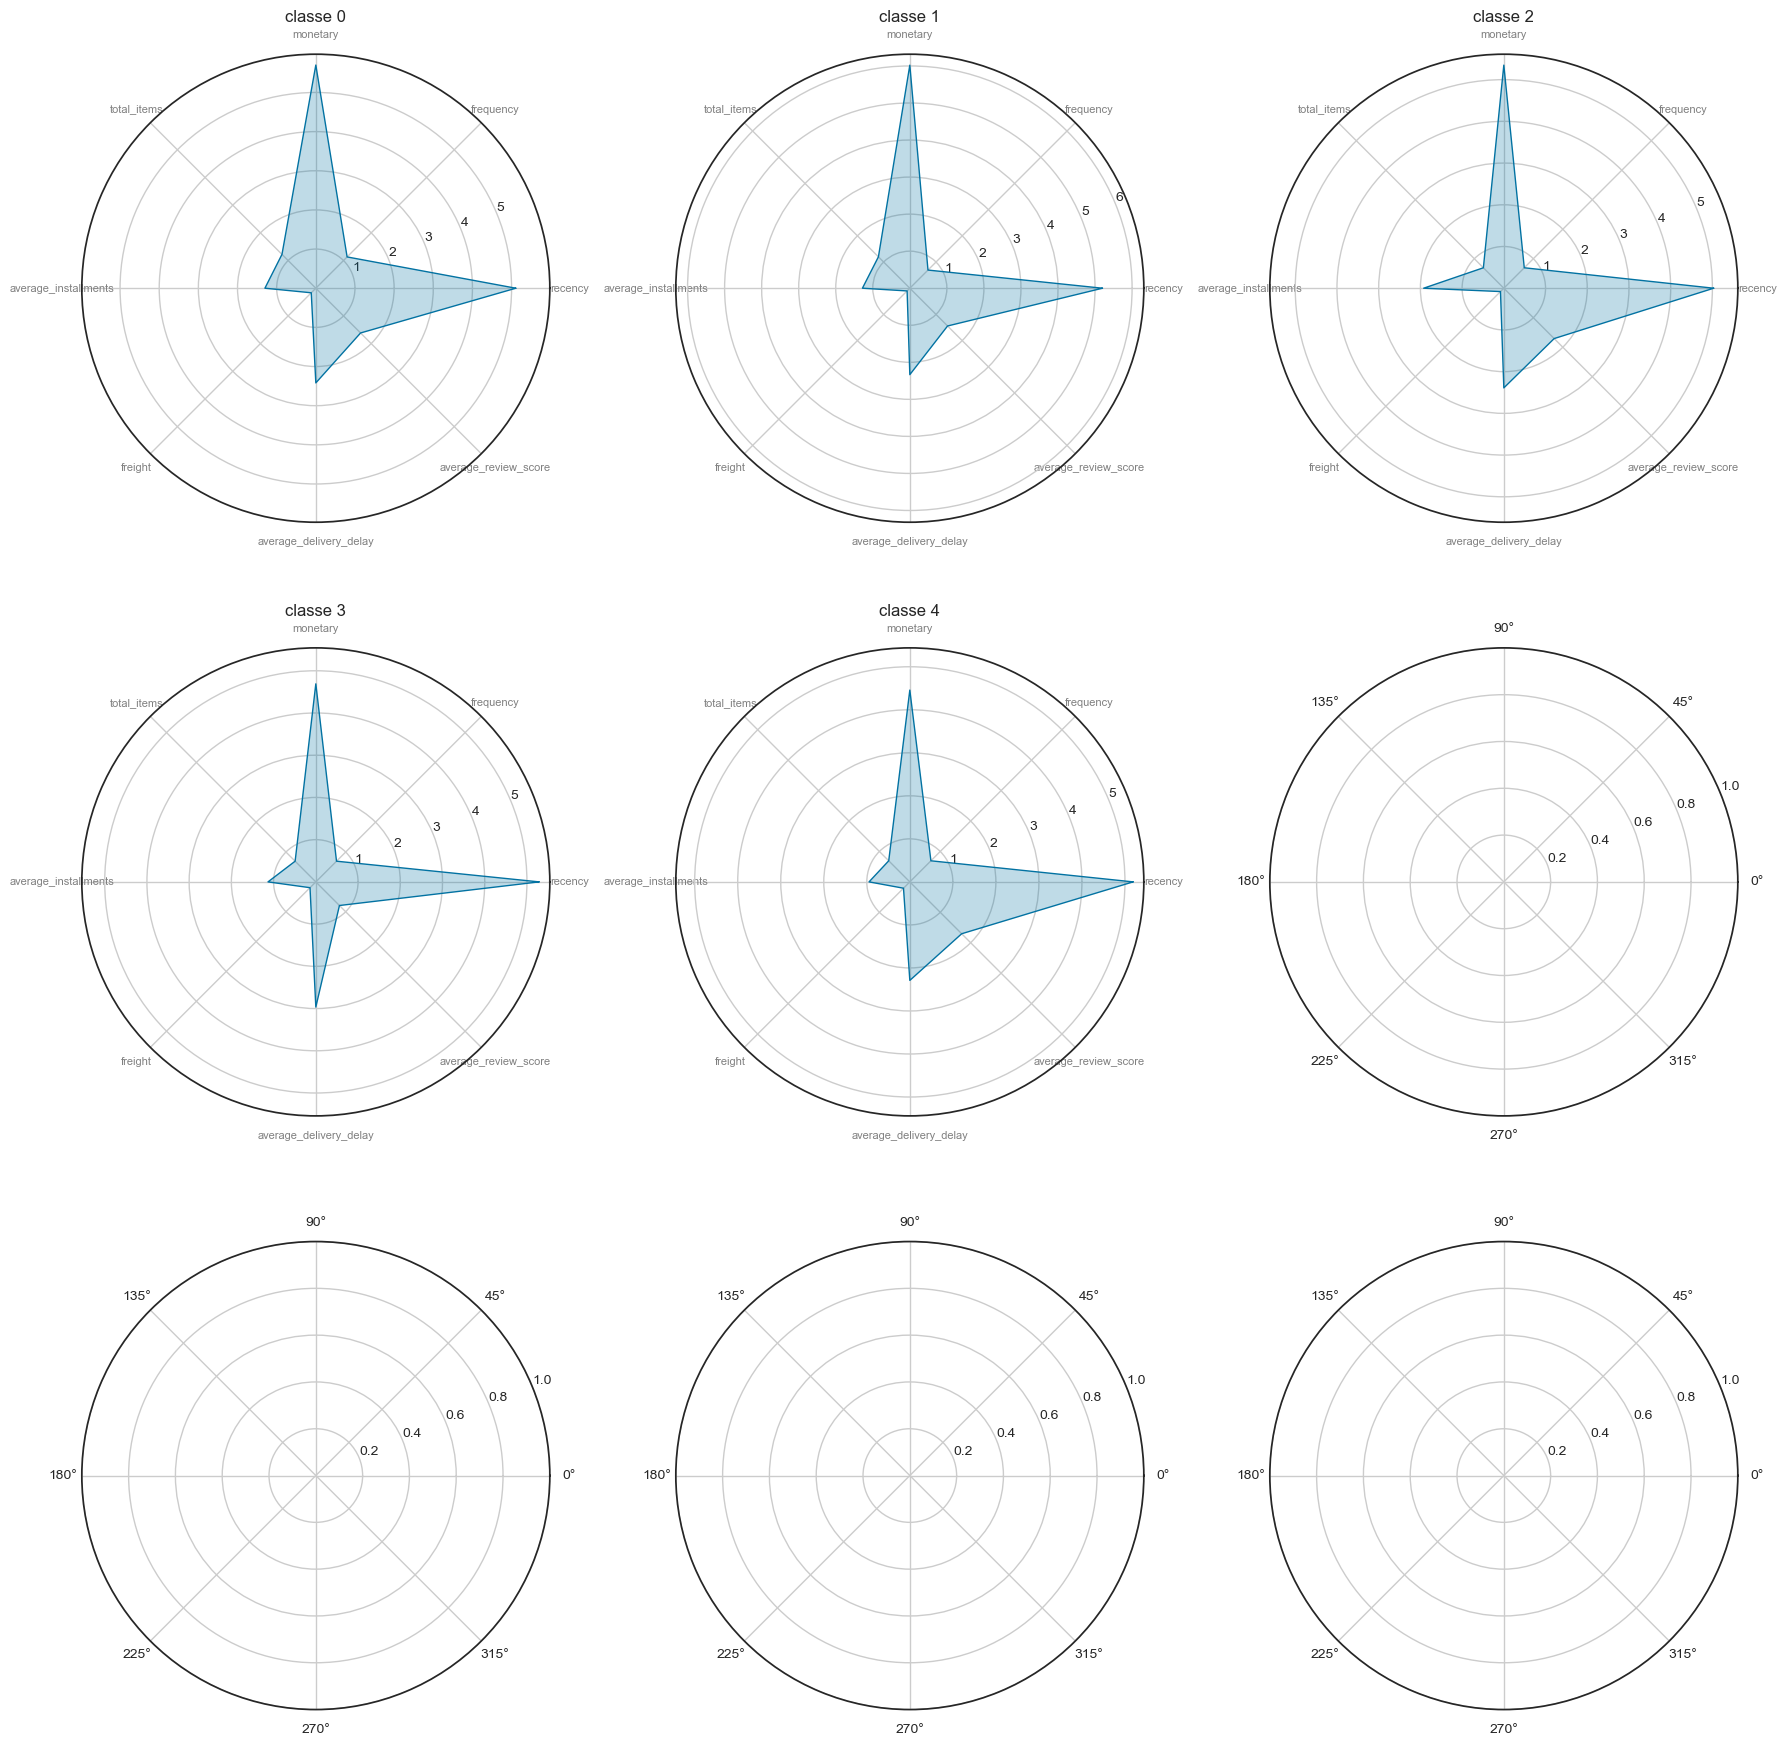

In [73]:
from math import pi

# Calculer les moyennes des variables par classe
variables = ['recency', 'frequency', 'monetary', 'total_items', 
             'average_installments', 'freight', 
             'average_delivery_delay', 'average_review_score']

classe_means = df_final_cah.groupby('classe')[variables].mean().reset_index()

# Nombre de classes
num_classes = len(classe_means)

# Créer un radar plot pour chaque classe
def create_radar_charts(classe_means, variables):
    # Nombre de variables
    num_vars = len(variables)

    # Angles pour chaque variable
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]

    # Initialiser le radar plot
    fig, axs = plt.subplots(3, 3, figsize=(18, 18), subplot_kw=dict(polar=True))
    axs = axs.flatten()

    for i in range(num_classes):
        values = classe_means.loc[i].drop('classe').values.flatten().tolist()
        values += values[:1]

        # Tracer les valeurs pour le classe
        axs[i].plot(angles, values, linewidth=1, linestyle='solid', label=f'classe {i}')
        axs[i].fill(angles, values, alpha=0.25)

        # Ajouter les labels pour chaque angle
        axs[i].set_xticks(angles[:-1])
        axs[i].set_xticklabels(variables, color='grey', size=8)

        # Ajouter un titre
        axs[i].set_title(f'classe {i}')

    # Ajuster l'affichage
    plt.tight_layout()
    plt.show()

# Créer et afficher les radar plots dans le même visuel
create_radar_charts(classe_means, variables)

Classe 1 : [Nouveaux] Les clients ont une faible fréquence de commandes et des délais de livraison moyens, mais donnent des avis modérément positifs.  
Classe 2 : [Insatisfaits] Les clients ont une fréquence de commandes très basse, des avis très négatifs et des délais de livraison élevés.  
Classe 3 : [Besoin d'attention] Les clients passent peu de commandes, ont des délais de livraison moyens et des avis légèrement négatifs.  
Classe 4 : [VIP] Les clients commandent fréquemment, ont des délais de livraison courts et laissent des avis très positifs.  
Classe 5 : [Loyaux] Les clients ont une fréquence de commandes modérée, des délais de livraison variables et des avis majoritairement neutres.  

- Exportation du modèle k-means

In [ ]:
import pickle

# Sauvegarde du modèle K-means
with open('kmeans_model.pkl', 'wb') as file:
    pickle.dump(kmeans, file)

print("Modèle K-means sauvegardé avec succès.")

- Exportation des dataframes

In [ ]:
df_log_scaled.to_csv('./df_log_scaled.csv', index=False, sep=';', encoding='utf-8')

In [ ]:
df.to_csv('./df.csv', index=False, sep=';', encoding='utf-8')